# FYP: Exploratory Data Analysis for HubSpot Data (2)
**FYP Goal:** Development of an AI/ML pipeline for pre-training a foundation model for sales

**EDA2 Goal:** Conduct Univariate Data Analysis on the processed SA_Singapore Dataset from EDA1 and identify transformation steps

**Data Source:** Preprocessed Data from EDA1

#### Data Columns from EDA1 (32)
1. ```Record ID```  
2. ```Company name```  
3. ```Campaign```  
4. ```Ideal Customer Profile```  
5. ```Industry (StaffAny Official)```  
6. ```Likelihood to close```  
7. ```Number of Associated Contacts```  
8. ```Number of times contacted```  
9. ```Is Billing Entity```  
10. ```Parent CompanyIDs```  
11. ```Child Company Count```  
12. ```Is Parent```  
13. ```Has Parent```  
14. ```Number of Appointments```  
15. ```Familiarity Score```  
16. ```Has Appointments```  
17. ```Associated Note Count```  
18. ```Is Lacking Note```  
19. ```Associated Note Strength```  
20. ```Weighted Associated Note Strength```  
21. ```Adjusted Note Count```  
22. ```Adjusted Note Strength```  
23. ```Weighted Adjusted Note Strength```  
24. ```Is Lacking Contact```  
25. ```Associated Contacts Strength```  
26. ```Adjusted Contact Count```  
27. ```Adjusted Contact Strength```  
28. ```Weighted Adjusted Contact Strength```  
29. ```Billing Entities Count```  
30. ```Has Churned```  
31. ```Time Known```  
32. ```Time Index```  
33. ```Weighted Time Index```  
34. ```Year```  

### 1. Import Libraries
First, we import the necessary Python libraries required for our analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import re
import datetime as dt
from scipy.stats import shapiro, normaltest, anderson, zscore, chisquare
from transformers import pipeline as hf_pipeline
from pprint import pprint
from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook/Lab
tqdm.pandas()

We also import the classifier used for feature engineering

In [2]:
classifier = hf_pipeline(model="facebook/bart-large-mnli")

/Users/michael/Downloads/projects/FYP/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We adjust the root of our directory correctly

In [3]:
# the root of your project, adjust according to the current path in the output
os.chdir('../')

And import the local modules we need

In [4]:
from src.api.api_token import HubSpotOAuthAPIToken
from src.api.service_factory import ServiceFactory
from src.config import HUBSPOT_OAUTH_TOKEN

As our dataset is high dimensional, we will also set the following option so we can view the full dataframe within the viewport when using head()

In [5]:
pd.set_option('display.max_columns', None)

### 2. Load Datasets
In the context of a data pipeline, this step is taken over by data retrieval and cache loading

#### Main Dataset

In [6]:
# Read the Data
working_df = pd.read_csv('data/SA_Singapore.csv')

#### Auxiliary Dataset - Deals

In [7]:
# Define the path to save/load the CSV file
sa_singapore_deals_csv_path = 'data/SA_Singapore_Deals.csv'

# List to store deal and pipeline information
records = []

# Check if the CSV already exists
if os.path.exists(sa_singapore_deals_csv_path):
    # If it exists, load the data from the CSV
    deals_df = pd.read_csv(sa_singapore_deals_csv_path)
    print("Data loaded from existing CSV file.")
else:
    # If the CSV does not exist, proceed with fetching data
    print("CSV file not found. Fetching data from the API...")
    # Iterate through each deal ID and retrieve the details
    # Replace empty lists with NaN and Drop NaN values
    all_deal_with_primary_company_ids = working_df['Deal with Primary CompanyIDs'].apply(lambda x: x if x != [] else pd.NA).explode().dropna().tolist()
    for deal_id in tqdm(all_deal_with_primary_company_ids, desc="Processing Deals"):
        try:
            # Update request parameters
            deal_service.update_get_params("properties", "dealstage,dealname,pipeline")
            
            # Fetch deal information
            deal = deal_service.get_deal_by_id(str(deal_id))
            pipeline = deal_service.get_deal_pipeline_by_id(deal['properties']['pipeline'], deal['properties']['dealstage'])
            
            # Extract relevant data from deal and pipeline objects
            deal_record = {
                "Deal ID": deal.get('id'),
                "Deal Stage ID": deal['properties'].get('dealstage'),
                "Pipeline ID": deal['properties'].get('pipeline'),
                "Deal Name": deal['properties'].get('dealname'),
                "Deal Label": pipeline.get('label'),
                "Deal Created Date": deal.get('createdAt'),
                "Deal Last Modified Date": deal['properties'].get('hs_lastmodifieddate'),
                "Deal Pipeline Placement": pipeline.get('displayOrder'),
                "Pipeline is Closed": pipeline['metadata'].get('isClosed'),
                "Pipeline Probability": pipeline['metadata'].get('probability'),
                "Pipeline Created Date": pipeline.get('createdAt'),
                "Pipeline Last Modified Date": pipeline['updatedAt']
            }
            
            # Append each deal record to the list
            records.append(deal_record)
    
        except Exception as e:
            # Print the exception and store the failed deal ID
            print(f"Failed to process deal ID {deal_id}: {e}")
    
    # Convert the list of records into a DataFrame
    deals_df = pd.DataFrame(records)

    # Save the DataFrame to the specified CSV file
    deals_df.to_csv(sa_singapore_deals_csv_path, index=False)
    print(f"Data saved to {sa_singapore_deals_csv_path}.")

Data loaded from existing CSV file.


#### Auxiliary Dataset - Zeroshot Note Classification

In [8]:
note_classification_cache_path = "data/SA_Singapore_ZeroShot_Note.csv"

# Load or create the cached DataFrame for `Associated Note` classification results
if os.path.exists(note_classification_cache_path):
    note_classification_df = pd.read_csv(note_classification_cache_path)
else:
    note_classification_df = pd.DataFrame(columns=["Record ID", "Adjusted Note Count"])

#### Auxiliary Dataset - Zeroshot Contact Classification

In [9]:
contact_classification_cache_path = "data/SA_Singapore_ZeroShot_Contact.csv"

# Load or create the cached DataFrame for `Associated Contact` classification results
if os.path.exists(contact_classification_cache_path):
    contact_classification_df = pd.read_csv(contact_classification_cache_path)
else:
    contact_classification_df = pd.DataFrame(columns=["Record ID", "Adjusted Contact Count"])

### 3. Compiled Processing Steps
We will apply the steps in EDA1 to process the data. Steps here will be used as templates for a resultant data preprocessing pipeline

In [10]:
# 'Company name'
working_df['Company name'] =  working_df['Company name'].astype('string').str.strip()

# 'Number of Associated Contacts' Column
working_df['Number of Associated Contacts'] = working_df['Number of Associated Contacts'].fillna(0).astype(np.int64)

# 'Number of times contacted' Column
working_df['Number of times contacted'] = working_df['Number of times contacted'].fillna(0).astype(np.int64)

# 'Parent CompanyIDs' Column
working_df['Parent CompanyIDs'] = working_df['Parent CompanyIDs'].astype('string')
working_df['Parent CompanyIDs'] = working_df['Parent CompanyIDs'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Parent CompanyIDs'] = working_df['Parent CompanyIDs'].apply(lambda x: [np.int64(np.float64(i)) for i in x] if isinstance(x, list) else x)
working_df['Parent CompanyIDs'] = working_df['Parent CompanyIDs'].astype('object')

# 'Associated Contact IDs'
working_df['Associated Contact IDs'] = working_df['Associated Contact IDs'].astype('string')
working_df['Associated Contact IDs'] = working_df['Associated Contact IDs'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Associated Contact IDs'] = working_df['Associated Contact IDs'].apply(lambda x: [np.int64(np.float64(i)) for i in x] if isinstance(x, list) else x)
working_df['Associated Contact IDs'] = working_df['Associated Contact IDs'].astype('object')

# 'Associated Note IDs'
working_df['Associated Note IDs'] = working_df['Associated Note IDs'].astype('string')
working_df['Associated Note IDs'] = working_df['Associated Note IDs'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Associated Note IDs'] = working_df['Associated Note IDs'].apply(lambda x: [np.int64(np.float64(i)) for i in x] if isinstance(x, list) else x)
working_df['Associated Note IDs'] = working_df['Associated Note IDs'].astype('object')

# 'Deal with Primary CompanyIDs' 
working_df['Deal with Primary CompanyIDs'] = working_df['Deal with Primary CompanyIDs'].astype('string')
working_df['Deal with Primary CompanyIDs'] = working_df['Deal with Primary CompanyIDs'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Deal with Primary CompanyIDs'] = working_df['Deal with Primary CompanyIDs'].apply(lambda x: [np.int64(np.float64(i)) for i in x] if isinstance(x, list) else x)
working_df['Deal with Primary CompanyIDs'] = working_df['Deal with Primary CompanyIDs'].astype('object')

# 'Child CompanyIDs'
working_df['Child CompanyIDs'] = working_df['Child CompanyIDs'].astype('string')
working_df['Child CompanyIDs'] = working_df['Child CompanyIDs'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Child CompanyIDs'] = working_df['Child CompanyIDs'].apply(lambda x: [np.int64(np.float64(i)) for i in x] if isinstance(x, list) else x)
working_df['Child CompanyIDs'] = working_df['Child CompanyIDs'].astype('object')

# 'Billing EntitiesIDs'
working_df['Billing EntitiesIDs'] = working_df['Billing EntitiesIDs'].astype('string')
working_df['Billing EntitiesIDs'] = working_df['Billing EntitiesIDs'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Billing EntitiesIDs'] = working_df['Billing EntitiesIDs'].apply(lambda x: [np.int64(np.float64(i)) for i in x] if isinstance(x, list) else x)
working_df['Billing EntitiesIDs'] = working_df['Billing EntitiesIDs'].astype('object')

# 'Billing Entities'
working_df['Billing Entities'] = working_df['Billing Entities'].astype('string')
working_df['Billing Entities'] = working_df['Billing Entities'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Billing Entities'] = working_df['Billing Entities'].astype('object')

# 'Associated Contact'
working_df['Associated Contact'] = working_df['Associated Contact'].astype('string')
working_df['Associated Contact'] = working_df['Associated Contact'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Associated Contact'] = working_df['Associated Contact'].astype('object')

# 'Associated Note'
working_df['Associated Note'] = working_df['Associated Note'].astype('string')
working_df['Associated Note'] = working_df['Associated Note'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Associated Note'] = working_df['Associated Note'].astype('object')

# 'Deal with Primary Company'
working_df['Deal with Primary Company'] = working_df['Deal with Primary Company'].astype('string')
working_df['Deal with Primary Company'] = working_df['Deal with Primary Company'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Deal with Primary Company'] = working_df['Deal with Primary Company'].astype('object')

# 'Child Company'
working_df['Child Company'] = working_df['Child Company'].astype('string')
working_df['Child Company'] = working_df['Child Company'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Child Company'] = working_df['Child Company'].astype('object')

# 'Parent Company'
working_df['Parent Company'] = working_df['Parent Company'].astype('string')
working_df['Parent Company'] = working_df['Parent Company'].apply(lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Parent Company'] = working_df['Parent Company'].astype('object')

# 'Campaign'
working_df['Campaign'] = working_df['Campaign'].astype('string')
working_df['Campaign'] = working_df['Campaign'].apply(lambda x: ["Unknown"] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Campaign'] = working_df['Campaign'].astype('object')
campaign_categories = working_df['Campaign'].explode().unique().tolist()

# 'Ideal Customer Profile'
working_df['Ideal Customer Profile'] = working_df['Ideal Customer Profile'].astype('string')
working_df['Ideal Customer Profile'] = working_df['Ideal Customer Profile'].apply(lambda x: ["Unknown"] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x])
working_df['Ideal Customer Profile'] = working_df['Ideal Customer Profile'].astype('object')
icp_categories = working_df['Ideal Customer Profile'].explode().unique().tolist()

# 'Industry (StaffAny Official)'
working_df['Industry (StaffAny Official)'] = working_df['Industry (StaffAny Official)'].fillna("Unknown").astype('category')
industry_categories = working_df['Industry (StaffAny Official)'].explode().unique().tolist()

# 'Company Country'
working_df['Company Country'] = working_df['Company Country'].fillna("Unknown").astype('category')
industry_categories = working_df['Company Country'].explode().unique().tolist()

# 'Last Activity Date'
working_df['Last Activity Date'] = pd.to_datetime(working_df['Last Activity Date'], errors='coerce', format='%Y-%m-%d %H:%M').fillna(pd.NaT)

# 'First Deal Created Date'
working_df['First Deal Created Date'] = pd.to_datetime(working_df['First Deal Created Date'], errors='coerce', format='%Y-%m-%d %H:%M').fillna(pd.NaT)

# 'Last Logged Call Date'
working_df['Last Logged Call Date'] = pd.to_datetime(working_df['Last Logged Call Date'], errors='coerce', format='%Y-%m-%d %H:%M').fillna(pd.NaT)

# 'First Contact Create Date'
working_df['First Contact Create Date'] = pd.to_datetime(working_df['First Contact Create Date'], errors='coerce', format='%Y-%m-%d %H:%M').fillna(pd.NaT)

# 'Create Date'
working_df['Create Date'] = pd.to_datetime(working_df['Create Date'], errors='coerce', format='%Y-%m-%d %H:%M').fillna(pd.NaT)

# 'Churn Date'
working_df['Churn Date'] = pd.to_datetime(working_df['Churn Date'], errors='coerce', format='%Y-%m-%d').fillna(pd.NaT)

# 'Is Billing Entity'
working_df['Is Billing Entity'] = working_df['Is Billing Entity'].fillna('No').apply(lambda x: True if x == 'Yes' else False)

# 'Likelihood to close'
working_df['Likelihood to close'] = working_df['Likelihood to close'].fillna(0)

#### Specific to this data set
A lot of incorrect `Company name` entries are found in this data set. A separate function for `Company name` checking should be considered. Assumption that data has been audited might not hold

In [11]:
working_df.drop(index=3369, inplace=True)
# Define regex pattern for variations of "NIL", "TEST", "-" or empty strings
pattern = r"^(?:NIL|TEST|-|\s*)$"
mask = working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)
matching_indices = working_df[mask].index
for i, idx in enumerate(matching_indices, start=1):
    working_df.loc[idx, 'Company name'] = f"Unknown Company {i}"

# Define regex pattern to match "StaffAny" or "[Test]" in 'Company name'
pattern = r"(StaffAny|\[Test\])"
# Remove rows where 'Company name' contains "StaffAny" or "[Test]"
working_df = working_df[~working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

/var/folders/w7/0y2_s8xn4qs8r_pdrgfsjcvc0000gn/T/ipykernel_13458/77146857.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  working_df = working_df[~working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


### 4. Compiled Features

In [12]:
working_df['Child Company Count'] = working_df['Child CompanyIDs'].apply(lambda x: len(x) if isinstance(x, list) else 0)
working_df['Is Parent'] = len(working_df['Parent CompanyIDs']) == 0
working_df['Has Parent'] = len(working_df['Parent CompanyIDs']) > 0

# `Number of Appointments`
working_df['Number of Appointments'] = 0
missing_ids =[]
for index, ids_list in working_df['Deal with Primary CompanyIDs'].items():
    if not ids_list:  # If the list is empty, set 'Number of Appointments' to 0
        working_df.at[index, 'Number of Appointments'] = 0
    else:
        # Filter deals_df to include only rows with Deal IDs in ids_list and where Deal Label is 'Appointment Set'
        matching_deals = deals_df[(deals_df['Deal ID'].isin(ids_list)) & (deals_df['Deal Label'].isin(['Appointment Set', 'Not Interested', 'Appointment Met']))]
        
        # Set the 'Number of Appointments' based on the number of matching deals
        working_df.at[index, 'Number of Appointments'] = len(matching_deals)

        # Identify any IDs in ids_list not found in deals_df
        missing_ids = set(ids_list) - set(deals_df['Deal ID'])
        if missing_ids:
            print(f"Missing Deal IDs for index {index}: {missing_ids}")

working_df['Familiarity Score'] = working_df.apply(lambda row: len(row['Deal with Primary CompanyIDs'])/row['Number of Appointments'] if row['Number of Appointments'] > 0 else 0,axis=1)
working_df['Has Appointments'] = working_df['Number of Appointments'] != 0
working_df['Associated Note Count'] = working_df['Associated Note IDs'].apply(lambda x: len(x) if isinstance(x, list) else 0)
working_df['Is Lacking Note'] = working_df['Associated Note Count'] == 0

# `Associated Note Strength`
average_note_count = working_df['Associated Note Count'].mean()
working_df['Associated Note Strength'] = working_df['Associated Note Count']/average_note_count

# `Weighted Associated Note Strength`
average_note_count_non_zero = working_df[working_df['Associated Note Count'] != 0]['Associated Note Count'].mean()
working_df['Weighted Associated Note Strength'] = working_df['Associated Note Count']/average_note_count_non_zero

# `Adjusted Note Count`
# classification function
def classify_note_batch_with_cache(record_id, note, cache_df=None):
    # Define labels
    note_labels = ["high-quality note", "generic note"]

    lookup_result = None
    
    # Check if the result is already in the cache
    if cache_df is not None:
        lookup_result = cache_df.loc[cache_df["Record ID"] == record_id, "Adjusted Note Count"]
    
    if lookup_result is not None and not lookup_result.empty:
        # Use cached value if it exists
        return lookup_result.iloc[0]
    
    # Perform classification if no cached result
    if not notes:
        adjusted_note_count = 0
    else:
        results = classifier(notes, note_labels)  # Classify batch of notes
        adjusted_note_count = sum(
            1 for result in results
            if result['labels'][0] == "high-quality note" and result['scores'][0] > 0.57
        )
    
    return adjusted_note_count

# Apply batch classification
working_df["Adjusted Note Count"] = working_df.progress_apply(
    lambda row: classify_note_batch_with_cache(row["Record ID"], row["Associated Note"], cache_df=note_classification_df), axis=1
)
new_records = working_df[~working_df["Record ID"].isin(note_classification_df["Record ID"])] # Filter out cached records
note_classification_df = pd.concat([note_classification_df, new_records[["Record ID", "Adjusted Note Count"]]]) # Append new records to cache
note_classification_df.to_csv(note_classification_cache_path, index=False) # Save the updated cache

# `Adjusted Note Strength`
average_quality_note_count = working_df["Adjusted Note Count"].mean()
working_df["Adjusted Note Strength"] = working_df["Adjusted Note Count"] / average_quality_note_count

# `Weighted Adjusted Note Strength`
average_quality_note_count_non_zero = working_df[working_df['Adjusted Note Count'] != 0]['Adjusted Note Count'].mean()
working_df["Weighted Adjusted Note Strength"] = working_df["Adjusted Note Count"] / average_quality_note_count_non_zero

working_df['Is Lacking Contact'] = working_df['Number of Associated Contacts'] == 0

# `Associated Contact Strength`
average_contact_count = working_df['Number of Associated Contacts'].mean()
working_df['Associated Contact Strength'] = working_df['Number of Associated Contacts']/average_contact_count

# `Weighted Associated Contact Strength`
average_contact_count_non_zero = working_df[working_df['Number of Associated Contacts'] != 0]['Number of Associated Contacts'].mean()
working_df['Weighted Associated Contact Strength'] = working_df['Number of Associated Contacts']/average_contact_count_non_zero

# `Adjusted Contact Count`
# classification function
def classify_contact_batch_with_cache(record_id, contact, cache_df=None):
    # Define labels
    contact_labels = ["high-quality contact information", "generic contact information"]

    lookup_result = None
    
    # Check if the result is already in the cache
    if cache_df is not None:
        lookup_result = cache_df.loc[cache_df["Record ID"] == record_id, "Adjusted Contact Count"]
    
    if lookup_result is not None and not lookup_result.empty:
        # Use cached value if it exists
        return lookup_result.iloc[0]
    
    # Perform classification if no cached result
    if not contact:
        adjusted_contact_count = 0
    else:
        results = classifier(contact, contact_labels)  # Classify batch of notes
        adjusted_contact_count = sum(
            1 for result in results
            if result['labels'][0] == "high-quality contact information" and result['scores'][0] > 0.7
        )
    
    return adjusted_contact_count

# Apply batch classification
working_df["Adjusted Contact Count"] = working_df.progress_apply(
    lambda row: classify_contact_batch_with_cache(row["Record ID"], row["Associated Contact"], cache_df=contact_classification_df), axis=1
)
new_records = working_df[~working_df["Record ID"].isin(contact_classification_df["Record ID"])] # Filter out cached records
contact_classification_df = pd.concat([contact_classification_df, new_records[["Record ID", "Adjusted Contact Count"]]]) # Append new records to cache
contact_classification_df.to_csv(contact_classification_cache_path, index=False) # Save the updated cache

# `Adjusted Contact Strength`
average_quality_contact_count = working_df["Adjusted Contact Count"].mean()
working_df["Adjusted Contact Strength"] = working_df["Adjusted Contact Count"] / average_quality_contact_count

# `Weighted Adjusted Contact Strength`
average_quality_contact_count_non_zero = working_df[working_df['Adjusted Contact Count'] != 0]['Adjusted Contact Count'].mean()
working_df["Weighted Adjusted Contact Strength"] = working_df["Adjusted Contact Count"] / average_quality_contact_count_non_zero

# `Billing Entities Count`
working_df['Billing Entities Count'] = 0
def update_billing_counts(be_row):
    billing_count = len(be_row['Billing EntitiesIDs']) # Extract the count for this [BE] row
    for parent_id in be_row['Parent CompanyIDs']:
        # Add the billing count to the matching Record ID in working_df
        working_df.loc[working_df['Record ID'] == parent_id, 'Billing Entities Count'] += billing_count
working_df.apply(
    lambda row: update_billing_counts(row) if '[BE]' in row['Company name'] else None,
    axis=1
)

# `Is Billing Entity`
working_df['Is Billing Entity'] = working_df['Billing Entities Count'] > 0

# `Has Churned`
working_df['Has Churned'] = working_df['Churn Date'].notna()

# `Time Known`
extraction_date = dt.datetime.strptime("2024-04-24 09:23", "%Y-%m-%d %H:%M") # replace with time.today() for new data
working_df['Time Known'] = (extraction_date - working_df['First Contact Create Date']).dt.days

# `Time Index`
extraction_date = dt.datetime.strptime("2024-04-24 09:23", "%Y-%m-%d %H:%M") # replace with time.today() for new data
working_df['Time Index'] = working_df['Time Known'] / working_df['Time Known'].mean()

# `Weighted Time Index`
extraction_date = dt.datetime.strptime("2024-04-24 09:23", "%Y-%m-%d %H:%M") # replace with time.today() for new data
non_empty_deals_average_time_known = working_df[working_df['Deal with Primary CompanyIDs'].apply(len) > 0]['Time Known'].mean()
working_df['Weighted Time Index'] = working_df.apply(lambda row: row['Time Known'] / non_empty_deals_average_time_known,axis=1)

# `Created Year`
working_df['Year'] = working_df['Create Date'].dt.year
year_categories = working_df['Year'].dropna().explode().unique().tolist()
working_df['Year'] = working_df['Year'].astype('category')

Missing Deal IDs for index 2617: {18860174396}
Missing Deal IDs for index 2769: {18327533137}
Missing Deal IDs for index 2818: {13285431716}
Missing Deal IDs for index 2950: {18127734063}
Missing Deal IDs for index 3303: {11728326265}
Missing Deal IDs for index 3503: {17748470610}
Missing Deal IDs for index 3514: {17864312069}
Missing Deal IDs for index 3719: {11728318259}


  0%|          | 0/3755 [00:00<?, ?it/s]

  0%|          | 0/3755 [00:00<?, ?it/s]

### 5. Compiled Dimensionality Reduction Steps

In [13]:
working_df.drop(columns=['Company Country','Parent Company'], inplace=True)
working_df.drop(columns=[col for col in working_df.columns if 'Date' in col], inplace=True)
working_df.drop(columns=[col for col in working_df.columns if 'ID' in col and col not in ['Record ID', 'Parent CompanyIDs']], inplace=True)
working_df.drop(columns=['Deal with Primary Company','Child Company','Billing Entities','Associated Note','Associated Contact'], inplace=True)
working_df = working_df[~working_df['Company name'].str.startswith('[BE]', na=False)]

We also need to note that the `Time Known`, `Time Index` & `Weighted Time Index` has NaN values since not all customers have contacts. This should be accounted for during analysis. Further more, certain data types are known categories and should be one hot encoded during post processing 

### 4. Univariate Data Analysis

The further analysis of non-numerical summaries should be dealt with at a later stage since they would require some conversion into categorical data. We will conduct some usual univariate tests for the purely numerical fields first. We will also ignore `ID` from analysis since it's just purely relational and necessary information have already been featured out

#### Combined Analysis

##### Numerical Descriptive Statistics 

In [14]:
working_df.select_dtypes(include=['number']).describe()

,Record ID,Likelihood to close,Number of Associated Contacts,Number of times contacted,Child Company Count,Number of Appointments,Familiarity Score,Associated Note Count,Associated Note Strength,Weighted Associated Note Strength,Adjusted Note Count,Adjusted Note Strength,Weighted Adjusted Note Strength,Associated Contact Strength,Weighted Associated Contact Strength,Adjusted Contact Count,Adjusted Contact Strength,Weighted Adjusted Contact Strength,Billing Entities Count,Time Known,Time Index,Weighted Time Index
count,3.239000e+03,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.00000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3048.000000,3048.000000,3048.000000
mean,8.163369e+09,2.580540,2.642482,15.147576,0.170114,0.460327,0.515591,1.97808,1.147665,0.609745,1.292374,1.147792,0.495797,1.050002,0.973664,2.143254,1.040589,0.900643,0.472985,983.111549,0.997744,0.973176
std,4.911351e+09,3.671376,4.028159,23.830596,0.624610,0.711385,1.413446,2.82337,1.638095,0.870306,2.090459,1.856593,0.801969,1.600607,1.484238,3.103900,1.507001,1.304328,3.008501,560.894121,0.569242,0.555225
min,6.376982e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001015,0.000990
25%,4.696690e+09,0.200000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397354,0.368466,1.000000,0.485518,0.420222,0.000000,469.000000,0.475981,0.464260
50%,7.926910e+09,1.440000,1.000000,7.000000,0.000000,0.000000,0.000000,1.00000,0.580192,0.308251,0.000000,0.000000,0.000000,0.397354,0.368466,1.000000,0.485518,0.420222,0.000000,886.500000,0.899695,0.877540
75%,1.150117e+10,3.435000,3.000000,19.500000,0.000000,1.000000,1.000000,3.00000,1.740575,0.924753,2.000000,1.776254,0.767266,1.192063,1.105397,2.000000,0.971037,0.840445,0.000000,1516.250000,1.538818,1.500926
max,2.042355e+10,55.510000,75.000000,430.000000,9.000000,6.000000,54.000000,23.00000,13.344407,7.089771,17.000000,15.098155,6.521760,29.801587,27.634921,58.000000,28.160072,24.372899,89.000000,2308.000000,2.342352,2.284674


##### Numerical Distributions

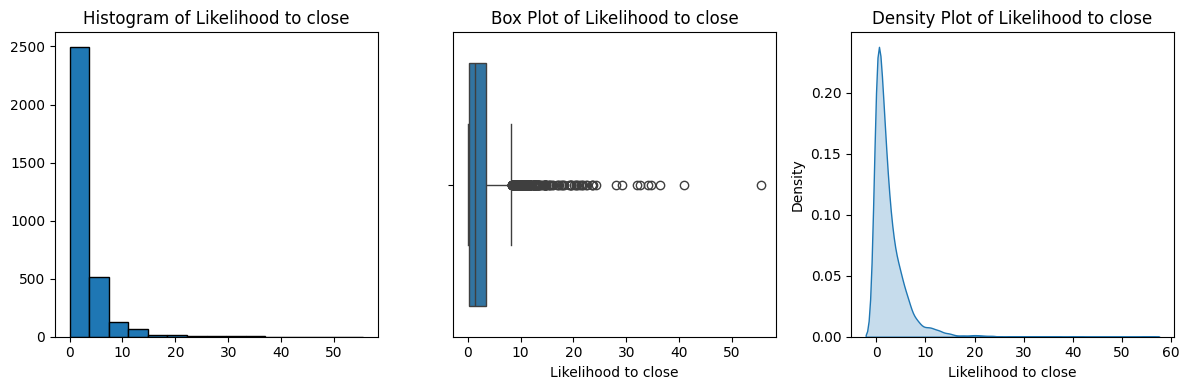

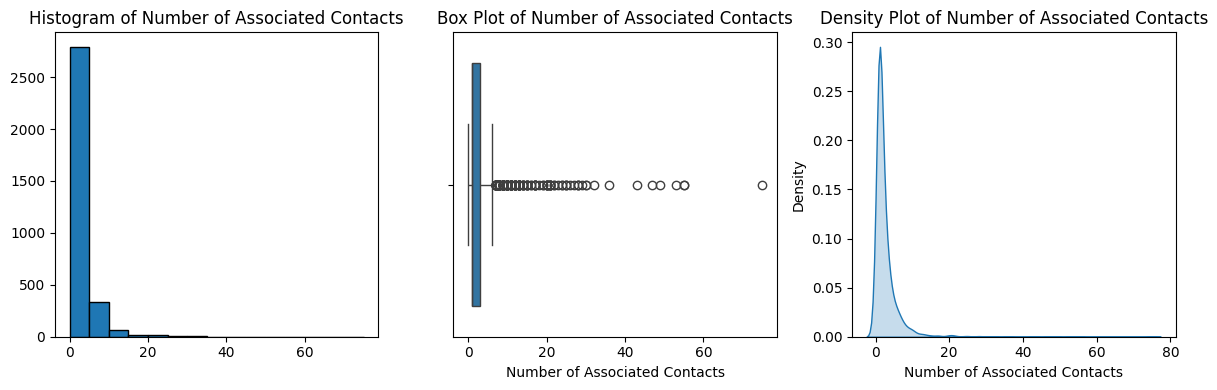

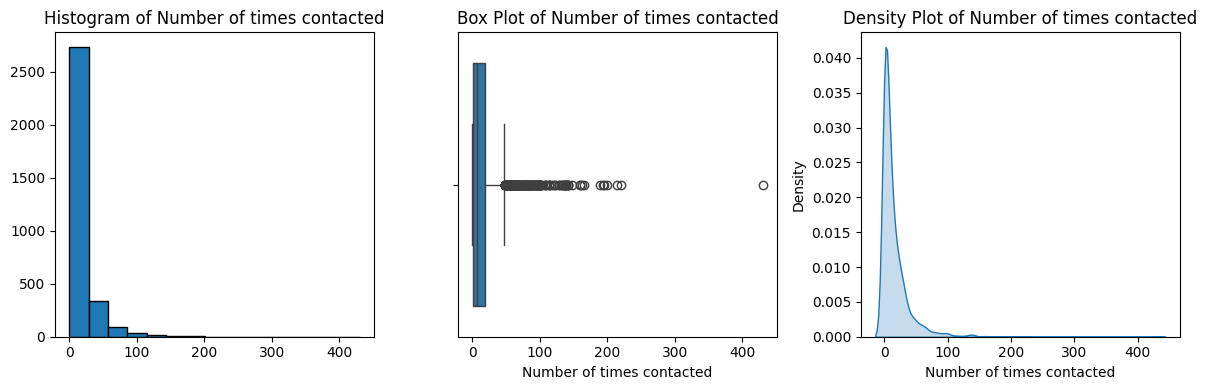

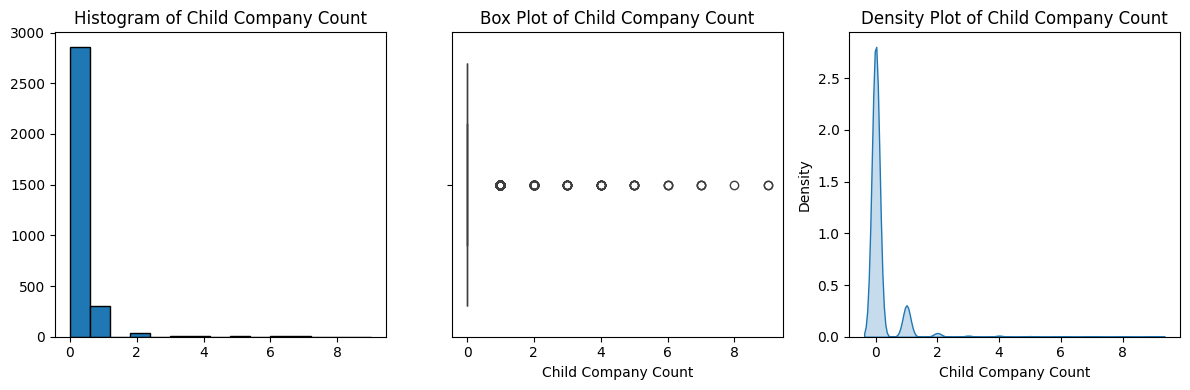

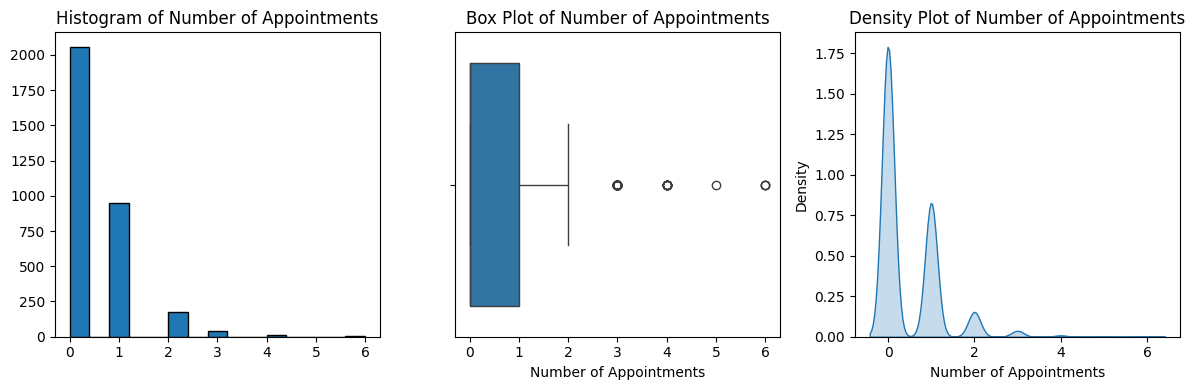

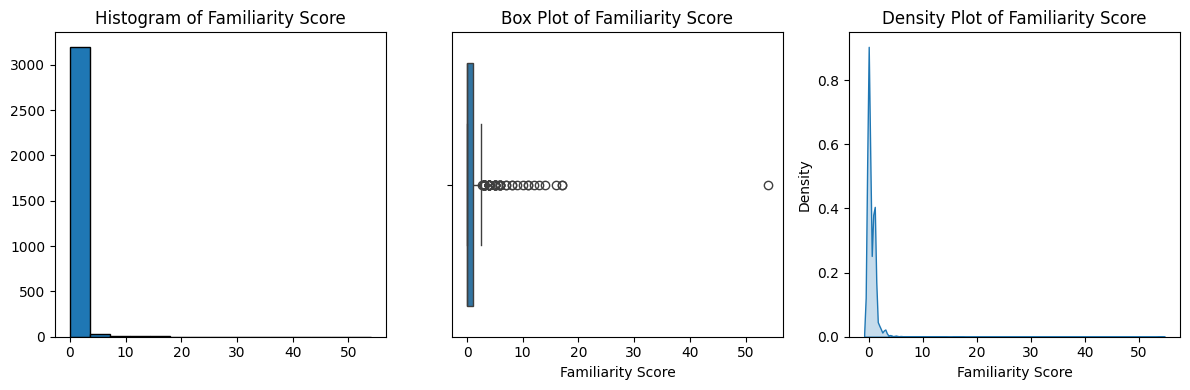

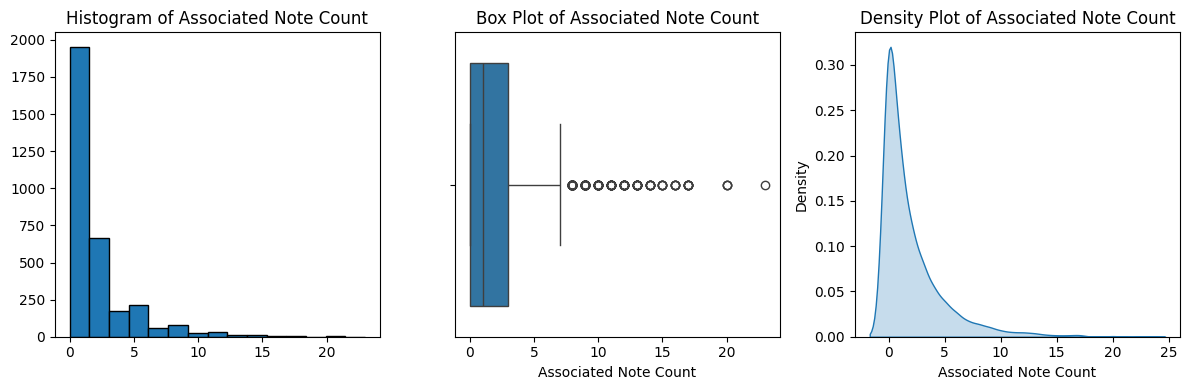

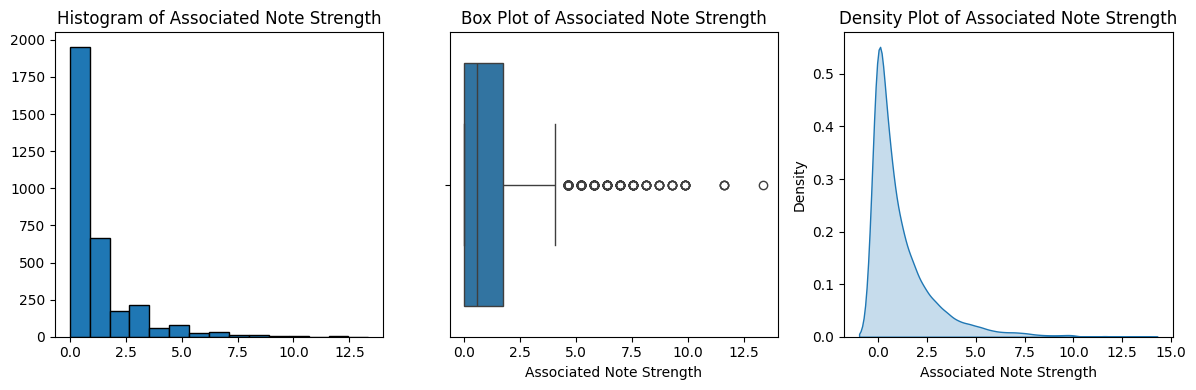

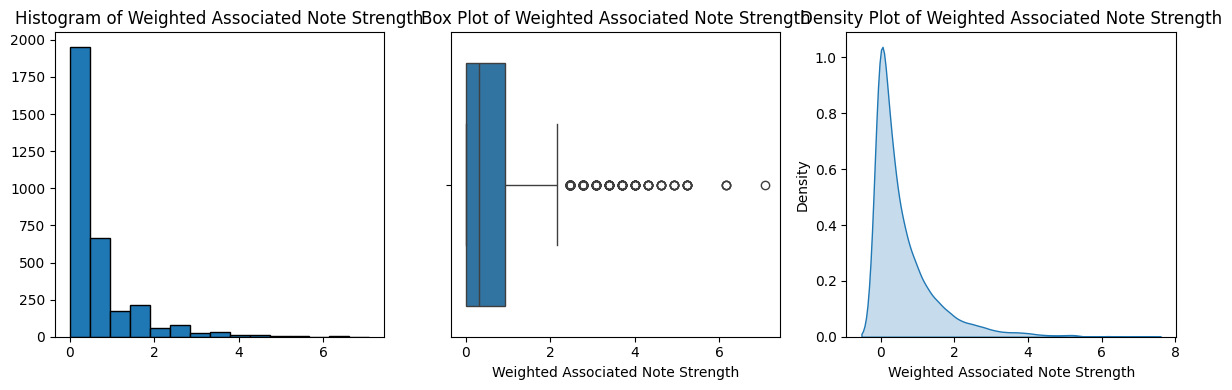

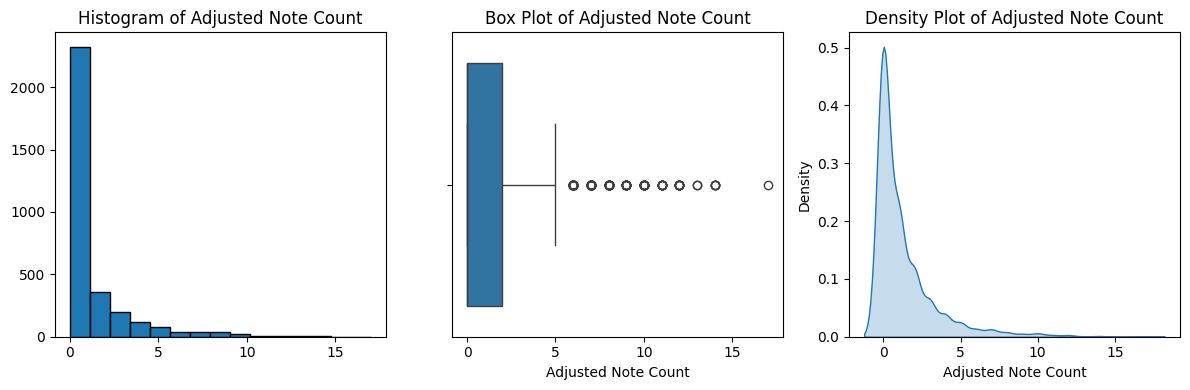

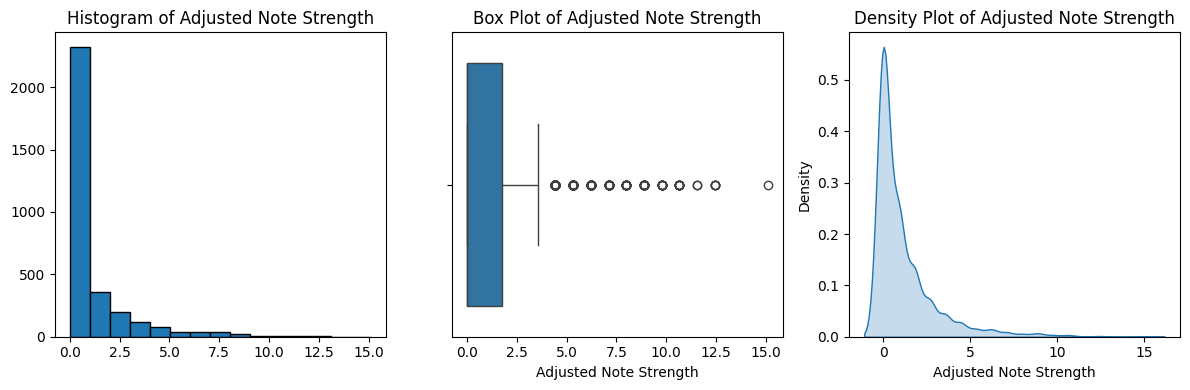

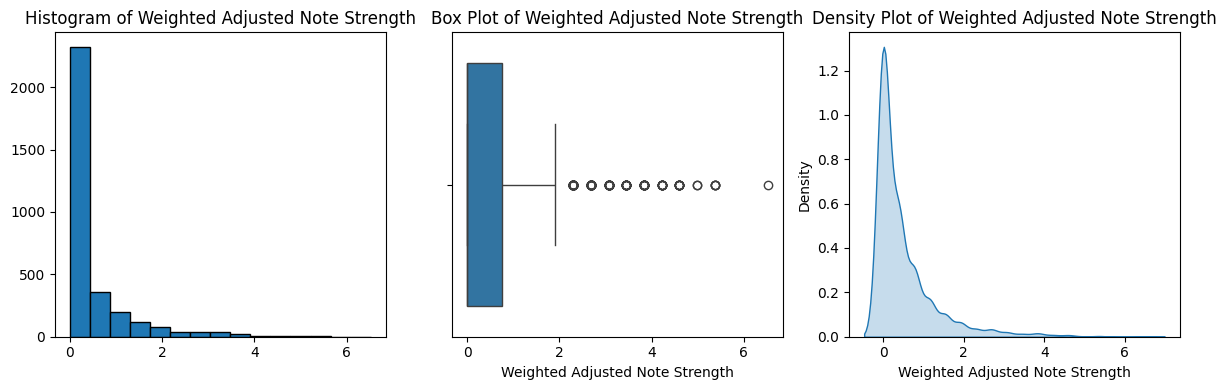

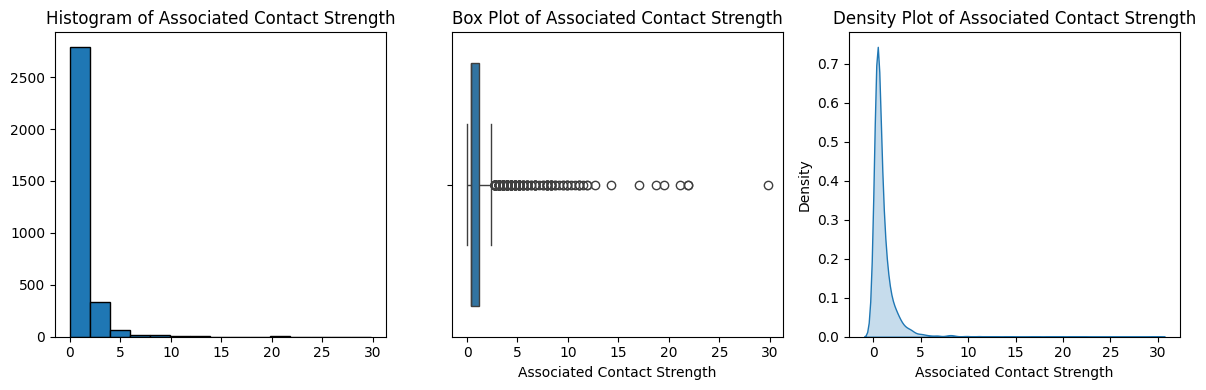

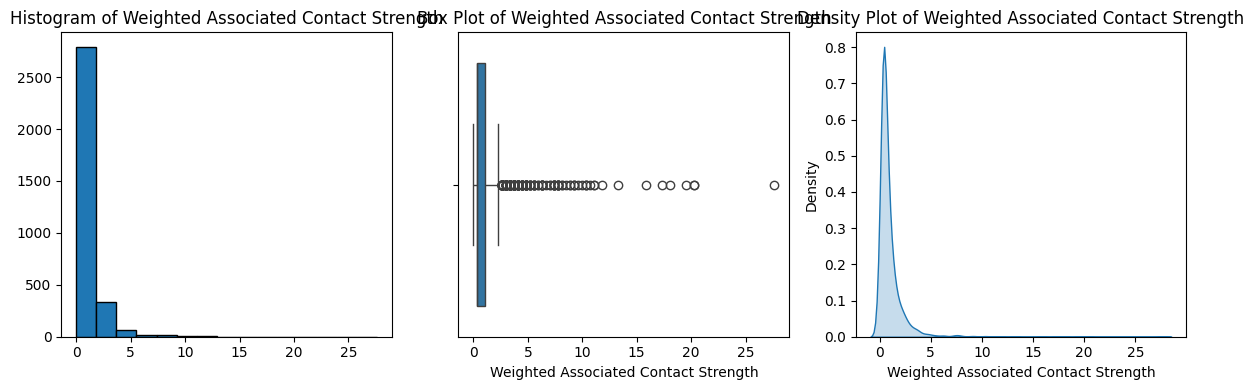

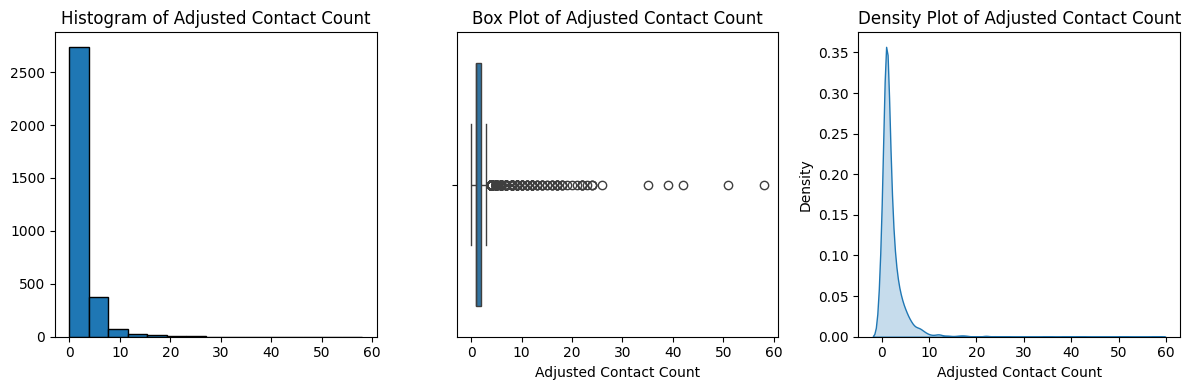

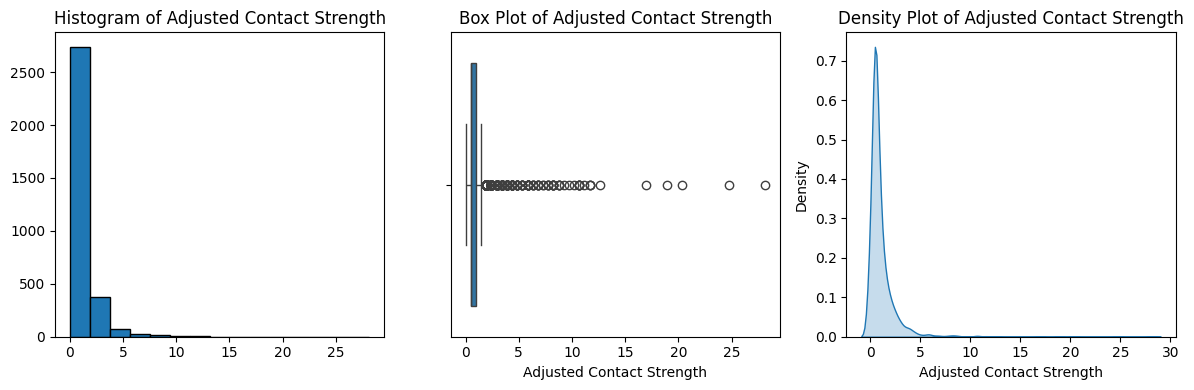

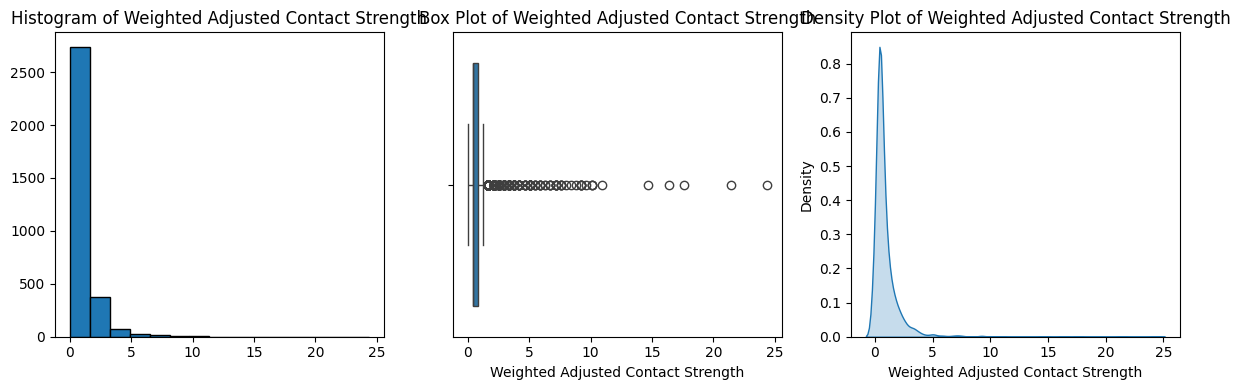

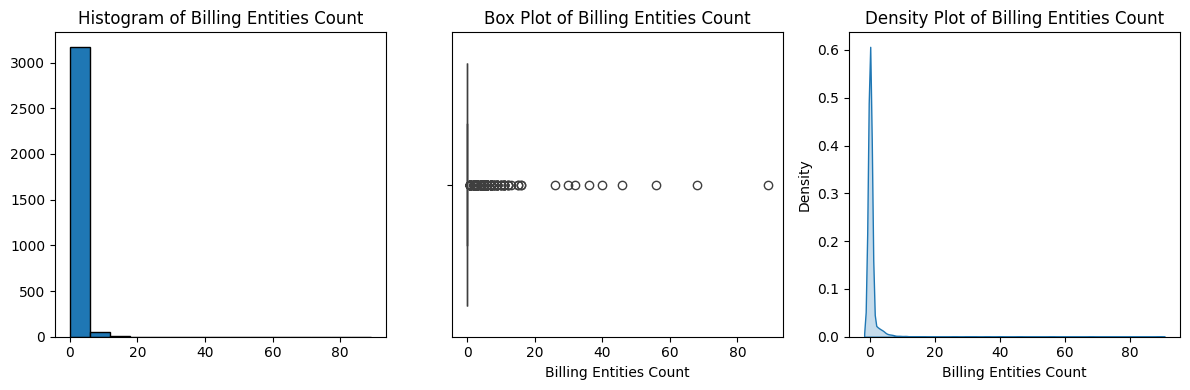

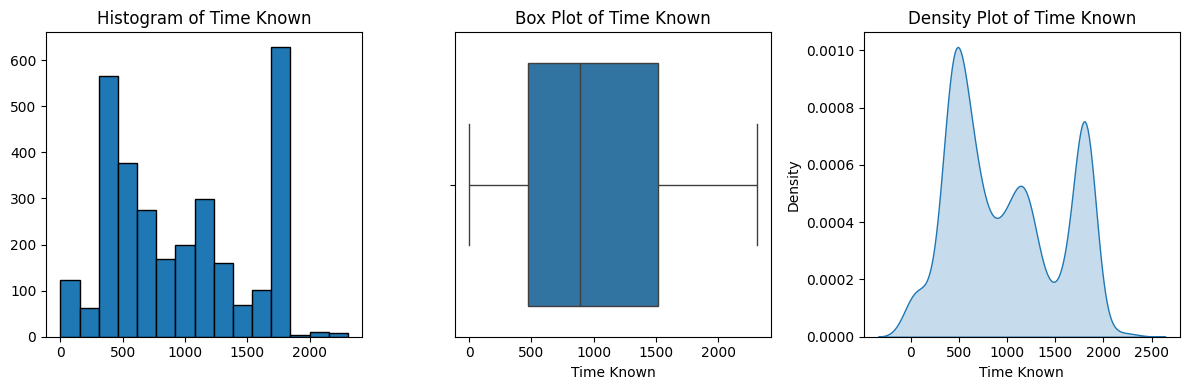

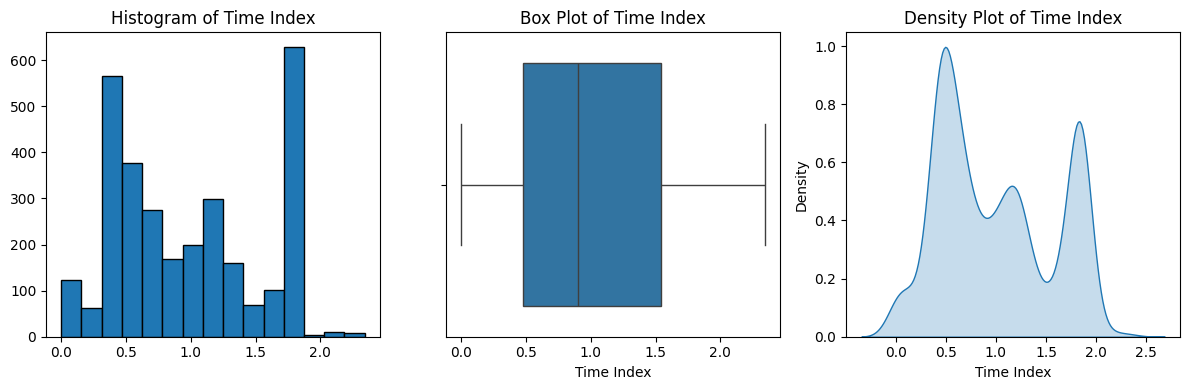

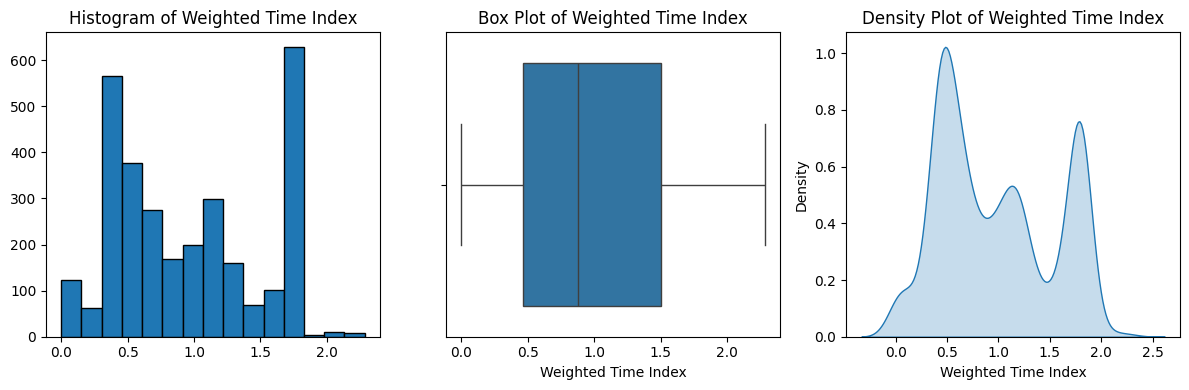

In [15]:
for col in working_df.select_dtypes(include=['number']).columns:
    if "ID" in col: continue
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(working_df[col].dropna(), bins=15, edgecolor='k')
    plt.title(f"Histogram of {col}")

    # Box Plot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=working_df[col])
    plt.title(f"Box Plot of {col}")

    # Density Plot
    plt.subplot(1, 3, 3)
    sns.kdeplot(working_df[col].dropna(), fill=True)
    plt.title(f"Density Plot of {col}")
    
    plt.tight_layout()
    plt.show()

*Informal Note for StaffAny - if Record ID is added sequentially, StaffAny's growth trajectory definitely seems to be slowing down, as they are acquiring fewer IDs towards the tail end of the distribution. FYI only*

##### Numerical Normality & Outlier Tests

In [16]:
results = {}

for col in working_df.select_dtypes(include=["number"]).columns:
    if "ID" in col: continue
    data = working_df[col].dropna()
    
    # Shapiro-Wilk Test
    shapiro_test = shapiro(data)
    # Kolmogorov-Smirnov Test
    ks_test = normaltest(data)
    # Anderson-Darling Test
    anderson_test = anderson(data)
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
    
    # Z-Score Method
    z_scores = zscore(data)
    z_outliers = data[np.abs(z_scores) > 3]
    
    results[col] = {
        'Shapiro-Wilk p-value': shapiro_test.pvalue,
        'Kolmogorov-Smirnov p-value': ks_test.pvalue,
        'Anderson-Darling statistic': anderson_test.statistic,
        'IQR Outliers Count': iqr_outliers.count(),
        'Z-Score Outliers Count': z_outliers.count()
    }

# Create a DataFrame from the normality_results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')
# Rename columns for clarity
results_df.columns = ['Shapiro-Wilk', 'Kolmogorov-Smirnov', 'Anderson-Darling','Outlier','Z-score']
results_df

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,Outlier,Z-score
Likelihood to close,5.603123e-63,0.000000e+00,253.720020,181,55
Number of Associated Contacts,9.685682e-72,0.000000e+00,460.900618,241,53
Number of times contacted,5.216560e-65,0.000000e+00,312.142400,229,67
Child Company Count,3.289308e-77,0.000000e+00,887.096700,380,37
Number of Appointments,6.857655e-63,1.635988e-302,444.273948,56,56
Familiarity Score,2.545942e-77,0.000000e+00,547.609141,94,29
Associated Note Count,2.101803e-59,0.000000e+00,278.354222,176,73
Associated Note Strength,2.101803e-59,0.000000e+00,278.354222,176,73
Weighted Associated Note Strength,2.101803e-59,0.000000e+00,278.354222,176,73
Adjusted Note Count,1.308841e-62,0.000000e+00,357.087262,164,83


##### Interpretation of Univariate Test for Numerical Data

General Interpretation:

- **Shapiro-Wilk Test** and **Kolmogorov-Smirnov Test :** a low p-value (typically below 0.05) suggests that the data **does not follow a normal distribution**
- **Anderson-Darling Statistic :** measures how far the data deviates from a normal distribution. Higher values indicate a stronger deviation from normality
- **IQR Method :** considers values outside the range $[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$ as outliers. It is robust to skewness but sensitive to data spread, often detecting outliers in highly skewed data.
- **Z-Score Method :** method flags values that are more than 3 standard deviations from the mean as outliers. It is more suitable for normally distributed data but can still highlight extreme values in other distributions.

|**Column**|**Interpretation**|
|-|-|
|**Likelihood to Close**|Significant deviation from normality; right-skewed with numerous outliers. Most values are near zero, with a long tail. Apply log or square root transformation for normalization.|
|**Number of Associated Contacts**|Strong non-normality; right-skewed distribution. Many values near zero with some large outliers. Transformation may help reduce skewness.|
|**Number of Times Contacted**|Right-skewed distribution with a peak near zero and few high values. Large number of outliers detected. Apply transformation or cap extreme values for better model performance.|
|**Child Company Count**|Highly non-normal, significant right skewness. Substantial variability with many outliers. Transformation or scaling could improve distribution.|
|**Number of Appointments**|Moderate right-skewed distribution with outliers. Consider transformation or treat outliers to normalize.|
|**Appointments Strength**|Mostly consistent with minimal outliers. Values cluster near zero and one, suggesting a categorical nature. Treat as a categorical feature if necessary.|
|**Associated Note Count**|Right-skewed with high outliers. Most values near zero, with some extreme values. Transformation might reduce skewness and improve analysis.|
|**Associated Note Strength**|Similar to **Associated Note Count**, this feature exhibits strong right skewness. Transformation is recommended.|
|**Weighted Associated Note Strength**|Highly skewed with numerous outliers. Consider applying log or robust scaling to address skewness and outlier influence.|
|**Adjusted Note Count**|Strong non-normality; right-skewed. Significant outliers detected. Transformation or capping extreme values may help.|
|**Adjusted Note Strength**|Similar behavior to **Adjusted Note Count**. Apply transformations to stabilize variance and reduce outlier impact.|
|**Associated Contacts Strength**|Right-skewed with many outliers. Transformation could reduce skewness and improve distribution.|
|**Adjusted Contact Count**|Extremely skewed distribution with numerous outliers. May benefit from capping or transformation.|
|**Adjusted Contact Strength**|Right-skewed distribution with high variability. Consider capping or using non-parametric models.|
|**Billing Entities Count**|Highly skewed with substantial outliers. Transformation is essential to normalize.|
|**Time Known**|Stable distribution with minimal skewness and no outliers. Suitable for analysis without transformation.|
|**Time Index**|Similar to **Time Known**, this feature shows a stable distribution with no outliers. Suitable for direct analysis.|
|**Weighted Time Index**|Consistent distribution with no outliers. Can be used without further transformation.|

Suggestions:

1. **Transform Data**: Strong right-skewed distributions in several variables; apply log or square root transformations to help in normalizing the data for models that assume normality. However, consider this transformation on variables with a meaningful zero point and without many zero values (since log transformations of zero are undefined).
2. **Treat Outliers**: The high number of outliers identified by both IQR and Z-score methods suggests that some variables have significant variability. 1) **Cap extreme values** to limit the impact of outliers without discarding valuable data. 2) **Apply robust scaling** to reduce the influence of outliers while preserving the overall distribution. 3) **Segment the data**: If outliers represent meaningful sub-groups (e.g., high-value customers), analyze these groups separately to avoid skewing overall results.
3. **Non-Parametric Methods**: The significant deviation from normality in most variables indicates that non-parametric methods (such as rank-based analyses or tree-based models) may yield more reliable results than parametric approaches that assume normality.
4. **Explore Feature Engineering**: Given that some variables like "Appointments Strength" and "Associated Note Strength" are highly clustered around specific values, consider 1) **Discretizing these variables** if they provide limited information as continuous values, especially if they represent inherent categories. 2) **Combining features** to capture interactions or patterns that may not be apparent in individual variables.
5. **Further Investigation of Outliers**: Analyze outliers to identify potential patterns, distinct behaviors, or possible data entry errors. For instance 1) **Cluster analysis on outliers** may reveal whether they represent specific customer segments with unique behaviors 2) **Inspect outlier data points individually** to see if they reflect meaningful insights (e.g., high engagement customers, large accounts) or if they are due to anomalies.
6. **Potential for Segmentation**: Given the variability and outlier behavior in customer engagement metrics, segmentation might uncover insights into different types of customers. For example, high engagement vs. low engagement customers could benefit from different strategies.
7. **Assess Model Robustness**: When using machine learning models, consider models that are robust to non-normality and outliers, such as decision trees or ensemble methods, which can handle skewed distributions more effectively than linear models.

##### Categorical Descriptive Statistics

In [17]:
working_df.select_dtypes(include=['object','category']).describe()

,Campaign,Ideal Customer Profile,Industry (StaffAny Official),Parent CompanyIDs,Year
count,3239,3239,3239,3239,3239
unique,10,47,18,89,8
top,[Unknown],[Unknown],Food & Beverages,[],2019
freq,1982,1288,1682,3138,907


In [18]:
# Identify categorical columns (object or category types)
categorical_columns = working_df.select_dtypes(include=['object', 'category']).columns

# Separate columns with lists from those with single categories
list_columns = []
single_category_columns = []

for col in categorical_columns:
    # Check if the column contains any list entries
    if 'ID' in col: continue
    if working_df[col].apply(lambda x: isinstance(x, list)).any():
        list_columns.append(col)  # This column has lists (multiple categories)
    else:
        single_category_columns.append(col)  # This column has single categorical values

##### Categorical Distributions

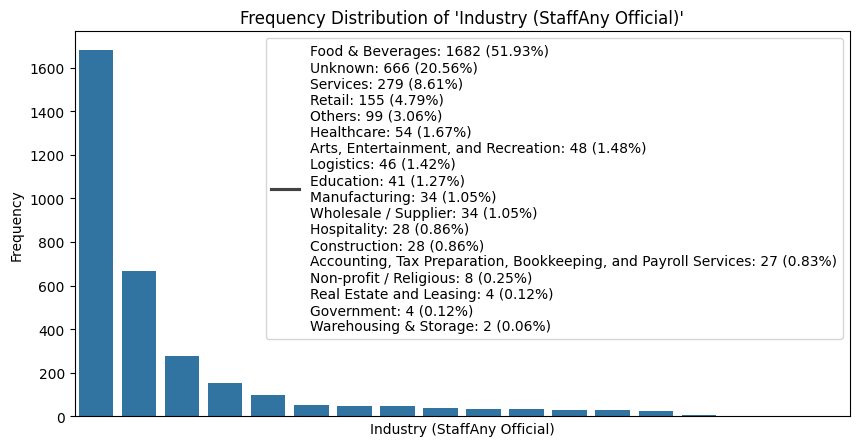

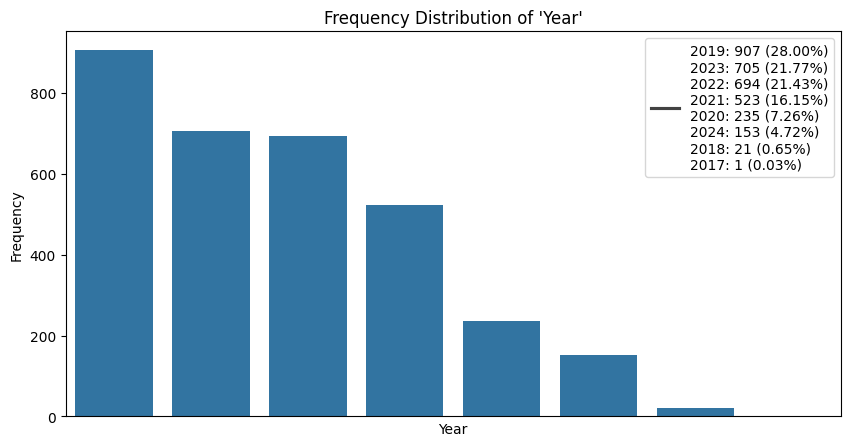

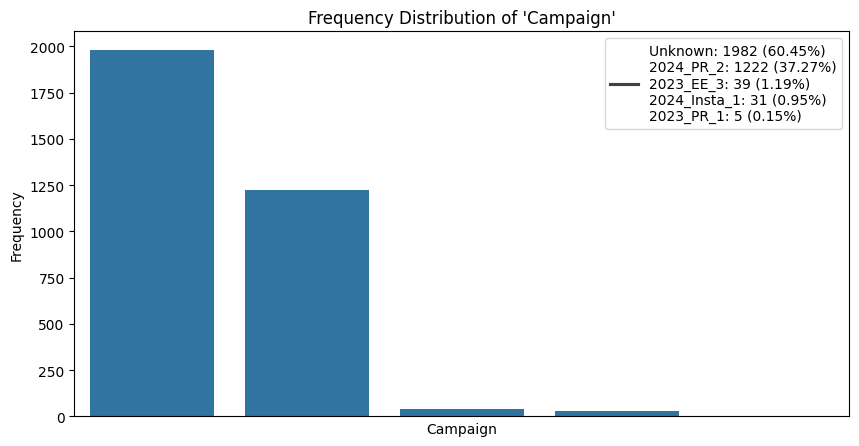

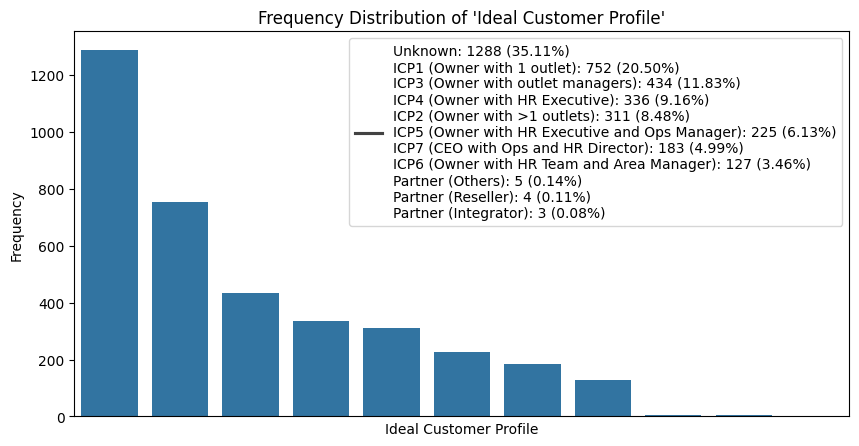

In [19]:
# Univariate analysis on single-category columns
for col in single_category_columns:
    # Calculate the frequency and percentage distribution
    freq = working_df[col].value_counts()
    perc = working_df[col].value_counts(normalize=True) * 100  # Percentage distribution
    
    # Prepare legend text
    legend_text = "\n".join([f"{index}: {value} ({perc[index]:.2f}%)" for index, value in zip(freq.index, freq.values)])
    
    # Plot frequency distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=freq.index, y=freq.values, order=freq.index)
    plt.title(f"Frequency Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks([])
    
    # Add legend with frequency and percentage information
    plt.legend([legend_text], loc='upper right', frameon=True, fontsize=10)
    plt.show()

# Univariate analysis on multi-category (list) columns
for col in list_columns:

    # Explode the column to transform each list element into its own row
    exploded_col = working_df.explode(col)
    
    # Drop any NaNs resulting from exploding
    exploded_col = exploded_col.dropna(subset=[col])
    
    # Calculate the frequency and percentage distribution
    freq = exploded_col[col].value_counts()
    perc = exploded_col[col].value_counts(normalize=True) * 100  # Percentage distribution

    # Prepare legend text
    legend_text = "\n".join([f"{index}: {value} ({perc[index]:.2f}%)" for index, value in zip(freq.index, freq.values)])
    
    # Plot frequency distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=freq.index, y=freq.values, order=freq.index)
    plt.title(f"Frequency Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks([])
    
    # Add legend with frequency and percentage information
    plt.legend([legend_text], loc='upper right', frameon=True, fontsize=10)
    plt.show()

##### Chi-Sqaure Goodness of Fit Test

In [20]:
# Create an empty DataFrame to store results
chi_square_results = pd.DataFrame(columns=['Column', 'Chi-Square Statistic', 'p-value', 'Conclusion'])

# Chi-Square test for single-category columns
for col in single_category_columns:
    # Calculate observed frequencies
    observed_freq = working_df[col].value_counts()
    
    # Set up expected frequencies for a uniform distribution
    num_categories = len(observed_freq)
    total_count = observed_freq.sum()
    expected_freq = [total_count / num_categories] * num_categories
    
    # Perform Chi-Square Goodness of Fit Test
    chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Conclusion based on p-value
    conclusion = "Reject null hypothesis (Not uniform)" if p_value < 0.05 else "Fail to reject null hypothesis (Could be uniform)"
    
    # Append results using pd.concat
    chi_square_results = pd.concat([chi_square_results, pd.DataFrame({
        'Column': [col],
        'Chi-Square Statistic': [chi2_stat],
        'p-value': [p_value],
        'Conclusion': [conclusion]
    })], ignore_index=True)

# Chi-Square test for multi-category (list) columns
for col in list_columns:
    # Explode the column to transform each list element into its own row
    exploded_col = working_df.explode(col)
    
    # Drop any NaNs resulting from exploding
    exploded_col = exploded_col.dropna(subset=[col])
    
    # Calculate observed frequencies for the exploded data
    observed_freq = exploded_col[col].value_counts()
    
    # Set up expected frequencies for a uniform distribution
    num_categories = len(observed_freq)
    total_count = observed_freq.sum()
    expected_freq = [total_count / num_categories] * num_categories
    
    # Perform Chi-Square Goodness of Fit Test
    chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Conclusion based on p-value
    conclusion = "Reject null hypothesis (Not uniform)" if p_value < 0.05 else "Fail to reject null hypothesis (Could be uniform)"
    
    # Append results using pd.concat
    chi_square_results = pd.concat([chi_square_results, pd.DataFrame({
        'Column': [col],
        'Chi-Square Statistic': [chi2_stat],
        'p-value': [p_value],
        'Conclusion': [conclusion]
    })], ignore_index=True)

# Display the results DataFrame
chi_square_results

/var/folders/w7/0y2_s8xn4qs8r_pdrgfsjcvc0000gn/T/ipykernel_13458/355826151.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi_square_results = pd.concat([chi_square_results, pd.DataFrame({


,Column,Chi-Square Statistic,p-value,Conclusion
0,Industry (StaffAny Official),15645.011732,0.0,Reject null hypothesis (Not uniform)
1,Year,2080.950602,0.0,Reject null hypothesis (Not uniform)
2,Campaign,4991.989631,0.0,Reject null hypothesis (Not uniform)
3,Ideal Customer Profile,4497.172846,0.0,Reject null hypothesis (Not uniform)


##### Interpretation of Univariate Test for Categorical Columns

| Column|Conclusion|
|-|-|
|**Industry (StaffAny Official)**|The distribution is highly skewed, dominated by Food & Beverages. Chi-Square test indicates non-uniformity.|
|**Year**|Entries are skewed towards recent years, especially 2019-2023. The distribution is non-uniform.|
|**Campaign**| Heavily dominated by 2024_PR_2. Chi-Square test indicates significant non-uniformity.|
|**Ideal Customer Profile**|The distribution is skewed towards certain profiles, especially ICP1. Chi-Square test confirms non-uniformity. |

Conclusions

1. **Industry (StaffAny Official)**: The data is heavily skewed towards the "Food & Beverages" industry, indicating a high concentration in this sector. The presence of a large "Unknown" category may suggest incomplete or generalized data entry practices.
2. **Year**: The distribution shows a higher number of entries from recent years, particularly 2019-2023, which could reflect business growth or data expansion over time.
3. **Campaign**: The "2024_PR_2" campaign overwhelmingly dominates, suggesting that most recorded entries are associated with this campaign, potentially due to recent marketing efforts or data entry practices.
4. **Ideal Customer Profile**: Certain customer profiles, like ICP1 and ICP3, are more prevalent, indicating a primary target demographic. Lower counts for partner profiles suggest fewer strategic partnerships.

##### Boolean Descriptive Statistics

In [21]:
working_df.select_dtypes(include=['bool']).describe()

,Is Billing Entity,Is Parent,Has Parent,Has Appointments,Is Lacking Note,Is Lacking Contact,Has Churned
count,3239,3239,3239,3239,3239,3239,3239
unique,2,1,1,2,2,2,2
top,False,False,True,False,False,False,False
freq,2952,3239,3239,2057,1947,3063,3054


##### Boolean Distributions

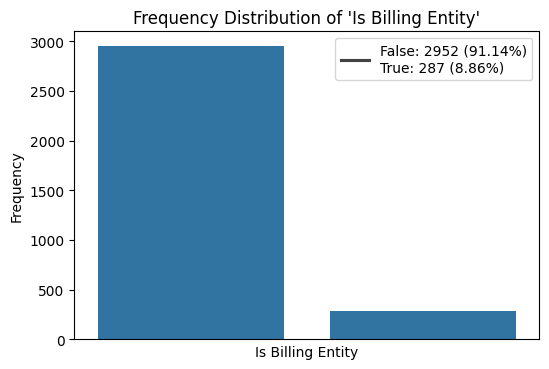

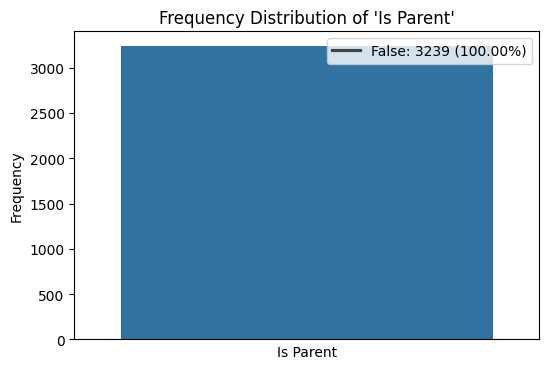

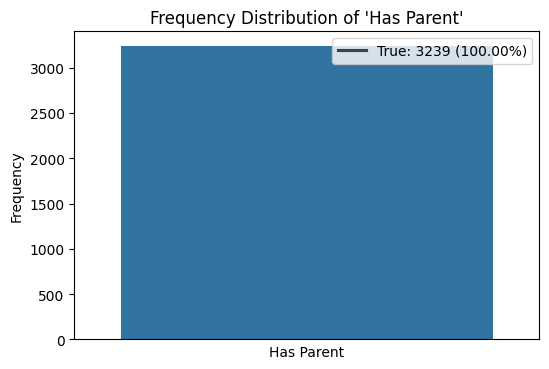

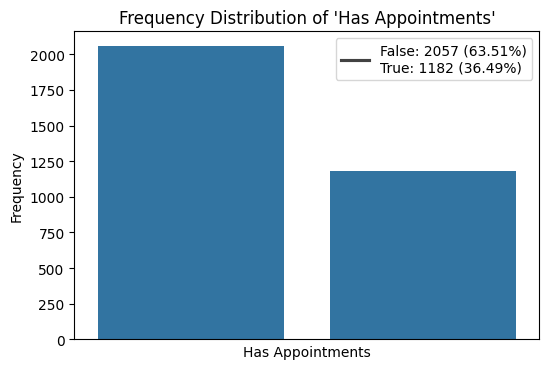

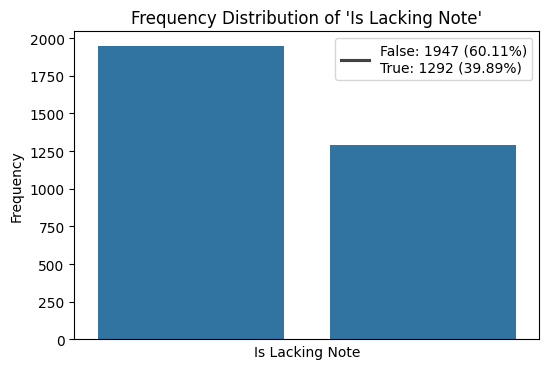

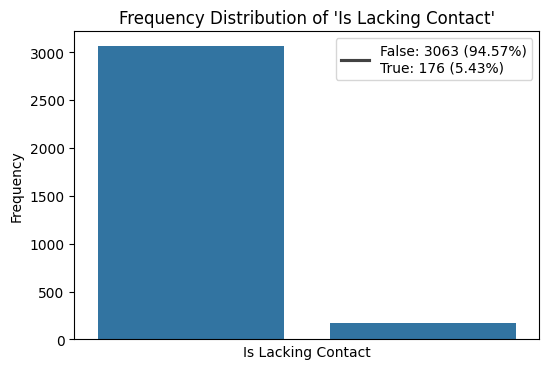

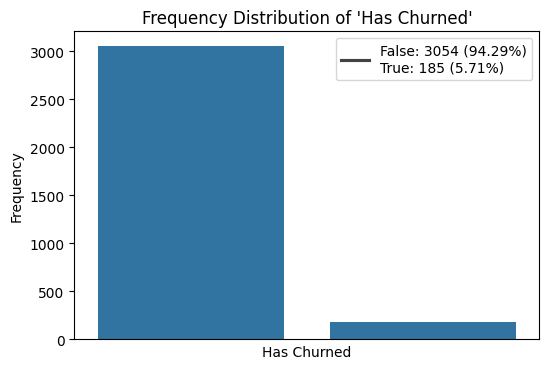

In [22]:
for col in working_df.select_dtypes(include=['bool']).columns:
    # Calculate frequency distribution
    freq = working_df[col].value_counts()
    perc = working_df[col].value_counts(normalize=True) * 100  # Percentage distribution

    # Prepare legend text
    legend_text = "\n".join([f"{index}: {value} ({perc[index]:.2f}%)" for index, value in zip(freq.index, freq.values)])
    
    # Plot frequency distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(x=freq.index.astype(str), y=freq.values)
    plt.title(f"Frequency Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks([])
    # Add legend with frequency and percentage information
    plt.legend([legend_text], loc='upper right', frameon=True, fontsize=10)
    plt.show()

##### Interpretation of Univariate Test for Categorical Columns

|Column|Interpretation|
|-|-|
|**Is Billing Entity**|Most entries are not billing entities, indicating a focus on companies without billing relationships.|
|**Is Parent**|The majority of entries represent parent companies, suggesting that the dataset focuses on higher-level entities rather than subsidiaries.|
|**Has Parent**|Few entries have a parent company, indicating that most entities are independent or stand-alone businesses.|
|**Has Appointments**|A significant portion of entries do not have appointments, which could indicate a lower level of active engagement.|
|**Is Lacking Note**|Most entries are documented with notes, suggesting thorough tracking and record-keeping for the majority of companies.|
|**Is Lacking Contact**|Very few entries lack contact information, indicating that contact details are generally well-maintained.|
|**Has Churned**|A low churn rate suggests strong customer retention or that the dataset primarily includes active companies.|

Conclusions

1. **Is Billing Entity**: Only a small proportion of companies are billing entities, indicating the dataset's focus may be on prospect or potential clients rather than paying customers.
2. **Is Parent & Has Parent**: Most entries are independent parent companies, with only a small subset having parent organizations, indicating a dataset centered on standalone entities.
3. **Has Appointments**: A lower percentage of entries with appointments suggests limited active engagement with some entities, possibly due to early stages in the sales cycle or lower engagement focus.
4. **Is Lacking Note**: Most companies are well-documented with notes, showing good record-keeping practices.
5. **Is Lacking Contact**: Almost all entries have contact information, suggesting an emphasis on maintaining communication details.
6. **Has Churned**: A low churn rate reflects strong customer retention or a focus on active clients, which could be beneficial for understanding long-term engagement.

#### Is Billing Entity == True Analysis

In [23]:
df_slice_BE = working_df[working_df['Is Billing Entity'] == True]

##### Numerical Descriptive Statistics

In [24]:
df_slice_BE.select_dtypes(include=['number']).describe()

,Record ID,Likelihood to close,Number of Associated Contacts,Number of times contacted,Child Company Count,Number of Appointments,Familiarity Score,Associated Note Count,Associated Note Strength,Weighted Associated Note Strength,Adjusted Note Count,Adjusted Note Strength,Weighted Adjusted Note Strength,Associated Contact Strength,Weighted Associated Contact Strength,Adjusted Contact Count,Adjusted Contact Strength,Weighted Adjusted Contact Strength,Billing Entities Count,Time Known,Time Index,Weighted Time Index
count,2.870000e+02,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,280.000000,280.000000,280.000000
mean,6.077679e+09,0.388990,7.006969,32.383275,1.327526,0.212544,1.120499,4.832753,2.803922,1.489700,3.466899,3.079046,1.330017,2.784251,2.581827,5.306620,2.576462,2.229961,5.337979,1420.939286,1.442089,1.406578
std,3.459411e+09,1.578098,9.894193,33.058744,1.089063,0.567274,4.181526,3.793614,2.201023,1.169385,3.121903,2.772646,1.197665,3.931502,3.645670,7.351566,3.569321,3.089292,8.741473,447.775073,0.454440,0.443250
min,6.376982e+08,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,53.000000,0.053789,0.052464
25%,2.473458e+09,0.000000,2.000000,10.500000,1.000000,0.000000,0.000000,2.000000,1.160383,0.616502,1.000000,0.888127,0.383633,0.794709,0.736931,1.000000,0.485518,0.420222,2.000000,1095.750000,1.112059,1.084676
50%,5.871638e+09,0.000000,4.000000,22.000000,1.000000,0.000000,0.000000,4.000000,2.320766,1.233004,3.000000,2.664380,1.150899,1.589418,1.473862,3.000000,1.456555,1.260667,3.000000,1579.500000,1.603009,1.563537
75%,9.003719e+09,0.000000,8.000000,44.000000,1.000000,0.000000,0.000000,7.000000,4.061341,2.157756,5.000000,4.440634,1.918165,3.178836,2.947725,5.000000,2.427592,2.101112,5.000000,1818.000000,1.845059,1.799626
max,1.932229e+10,14.620000,75.000000,214.000000,9.000000,4.000000,54.000000,20.000000,11.603832,6.165019,17.000000,15.098155,6.521760,29.801587,27.634921,58.000000,28.160072,24.372899,89.000000,2308.000000,2.342352,2.284674


##### Numerical Distributions

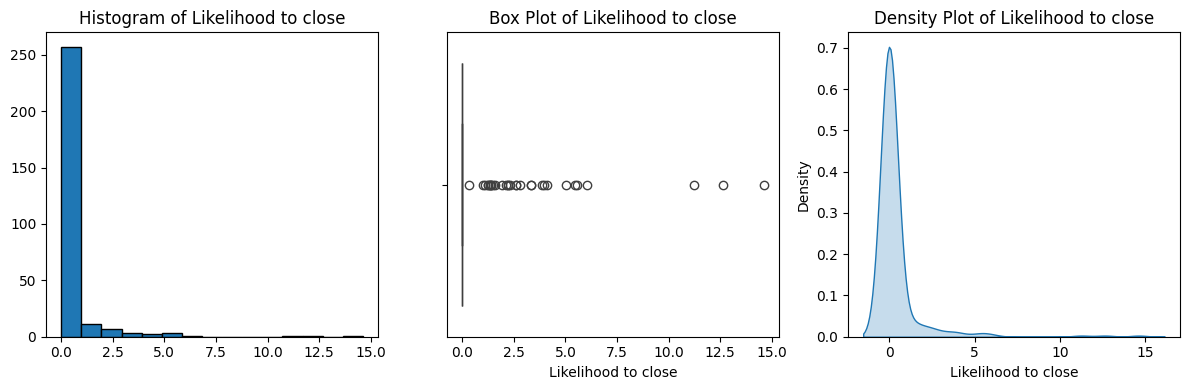

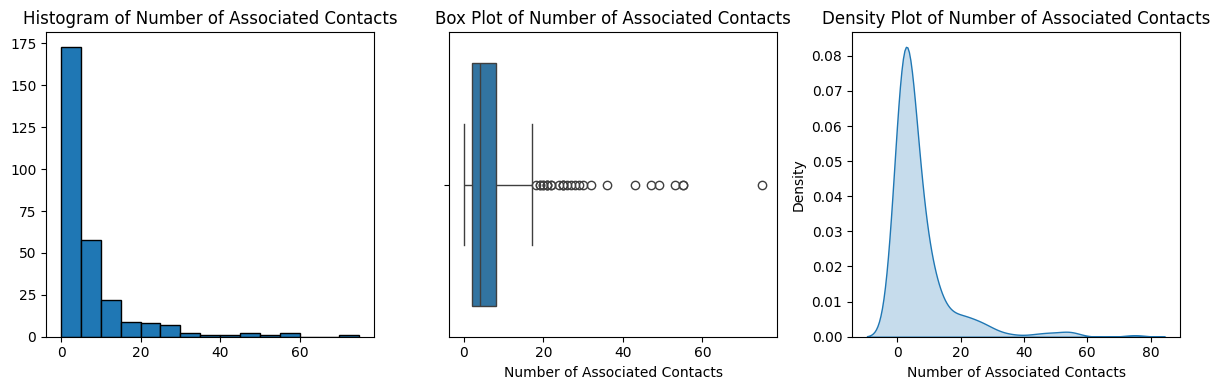

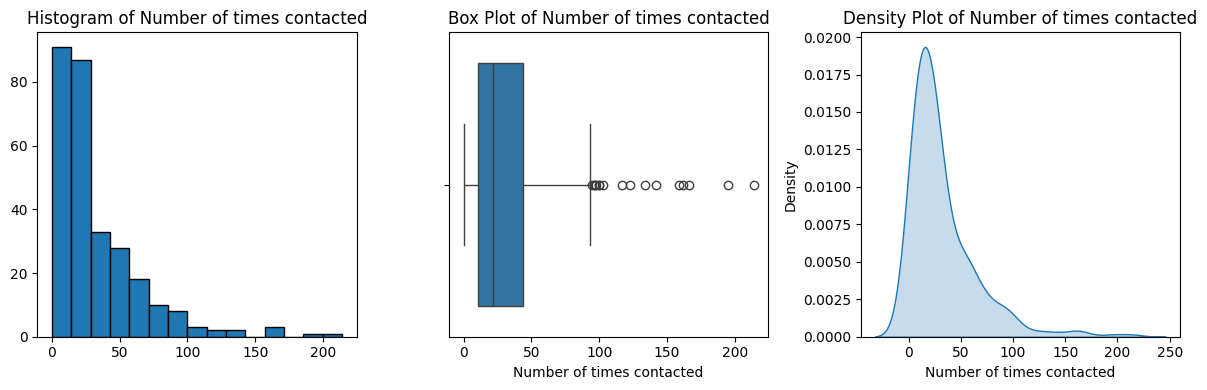

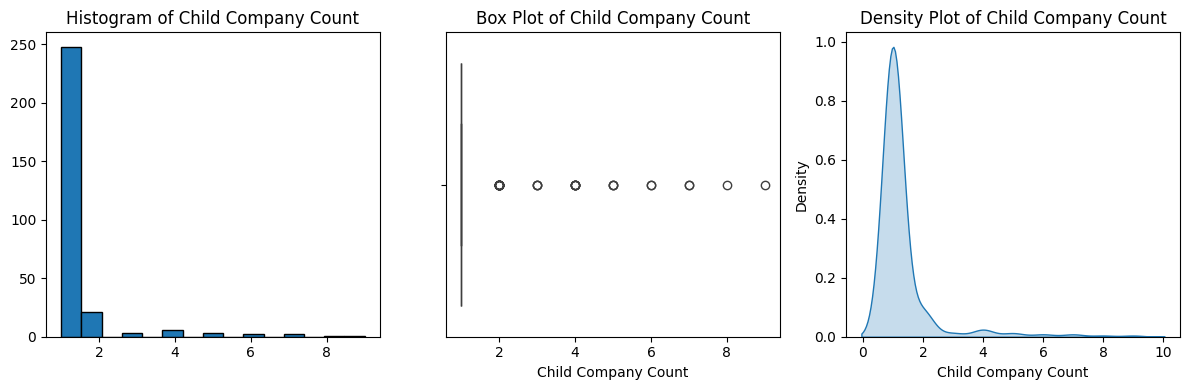

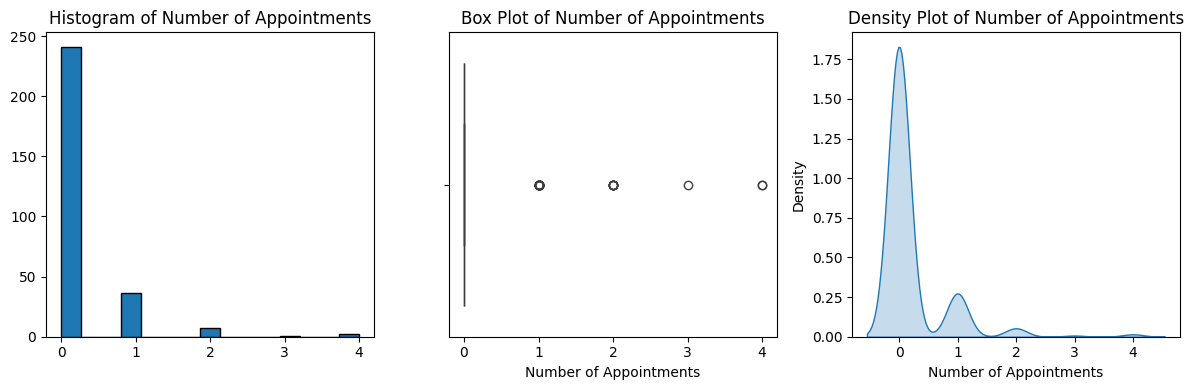

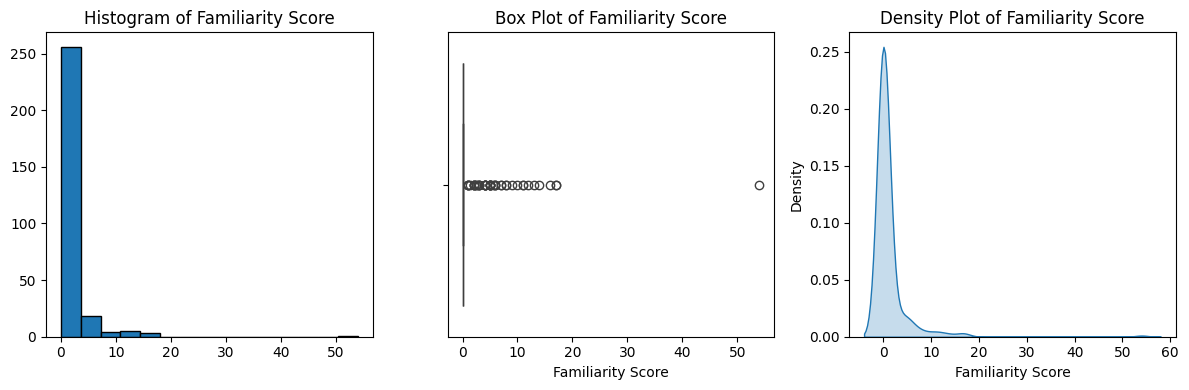

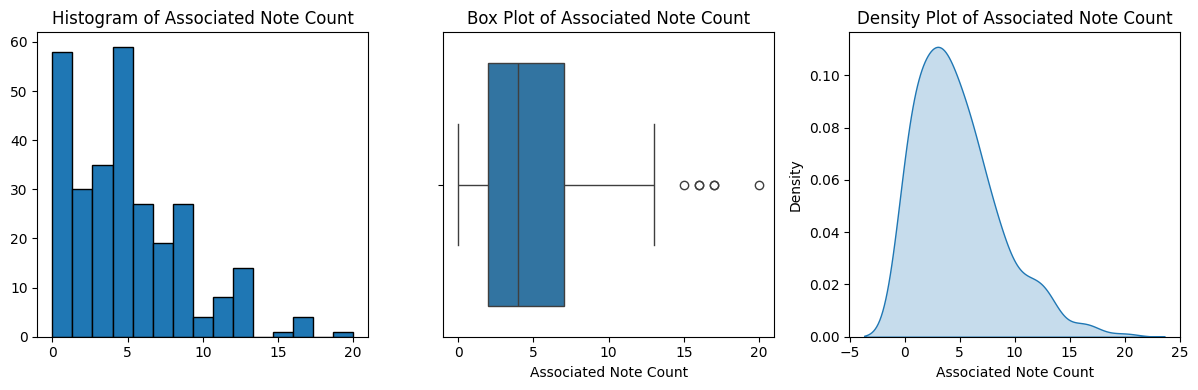

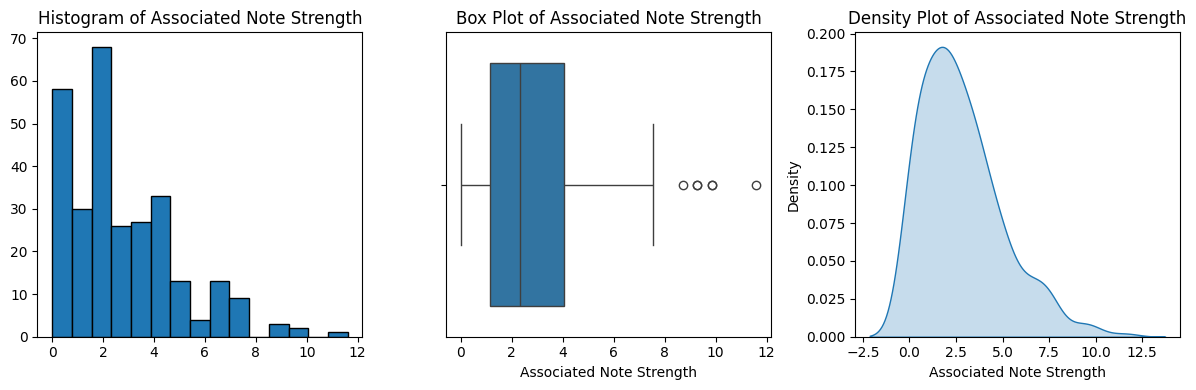

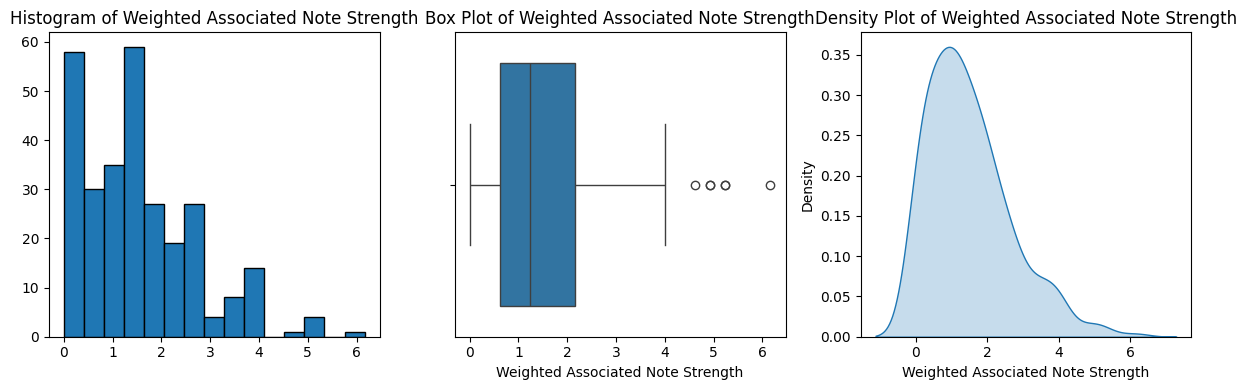

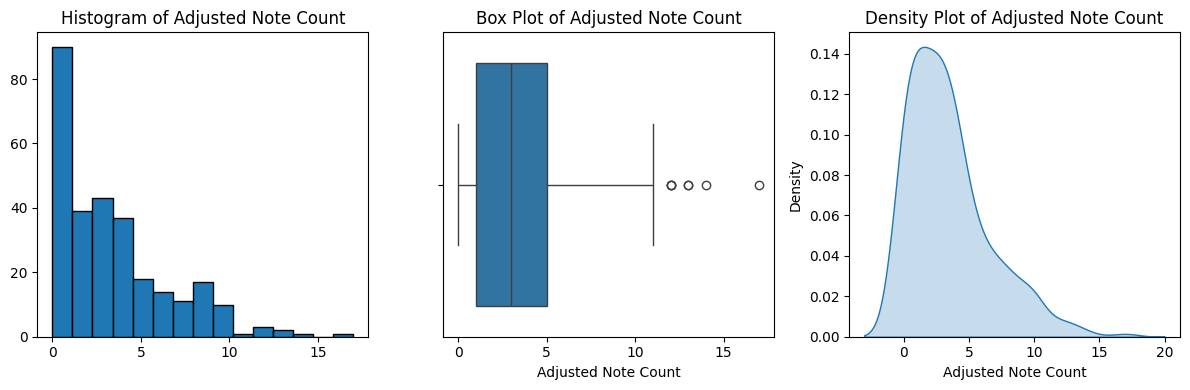

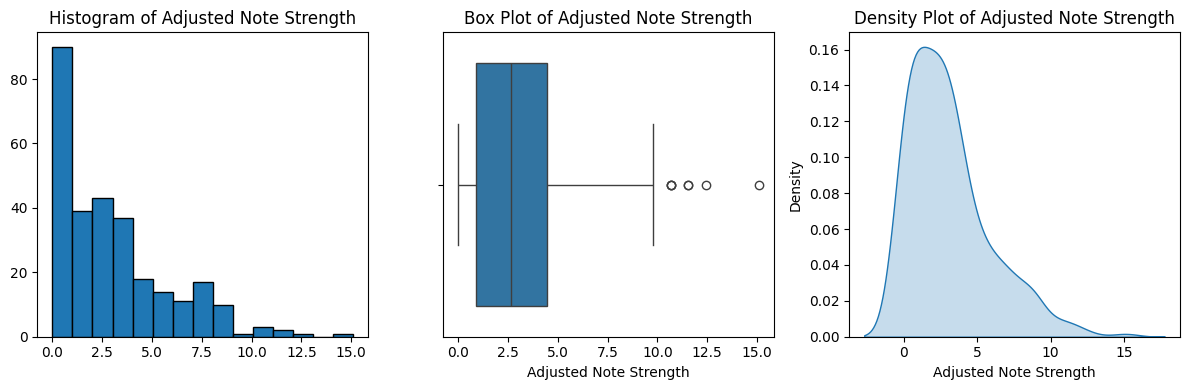

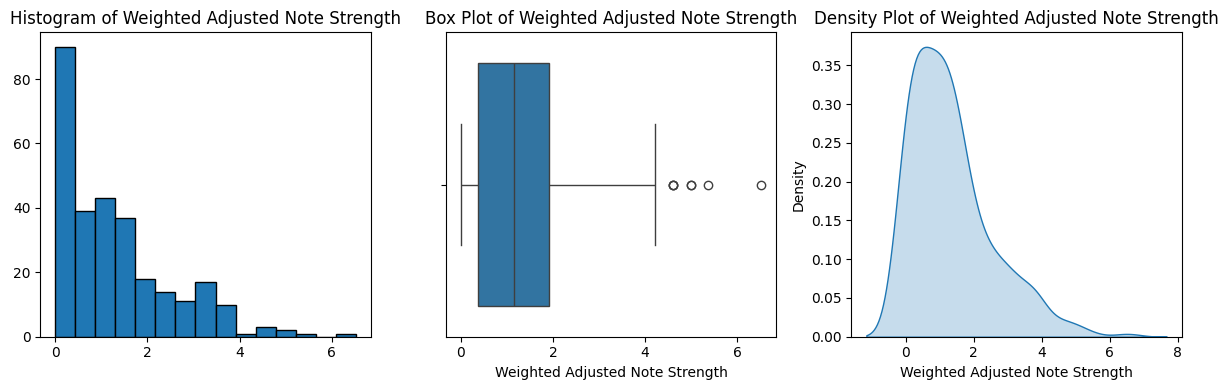

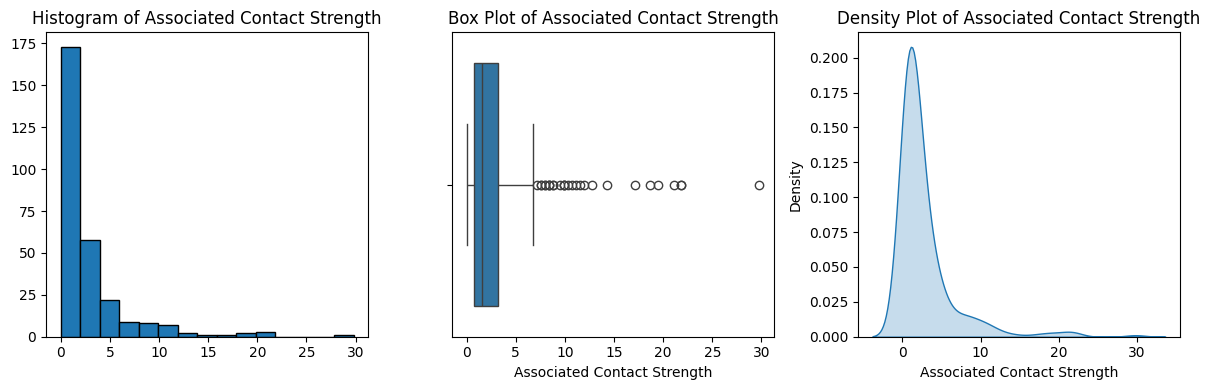

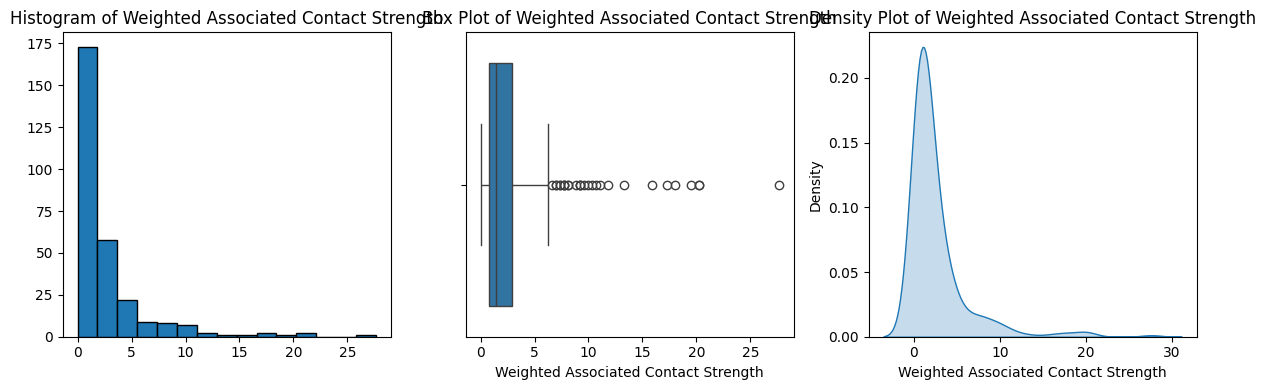

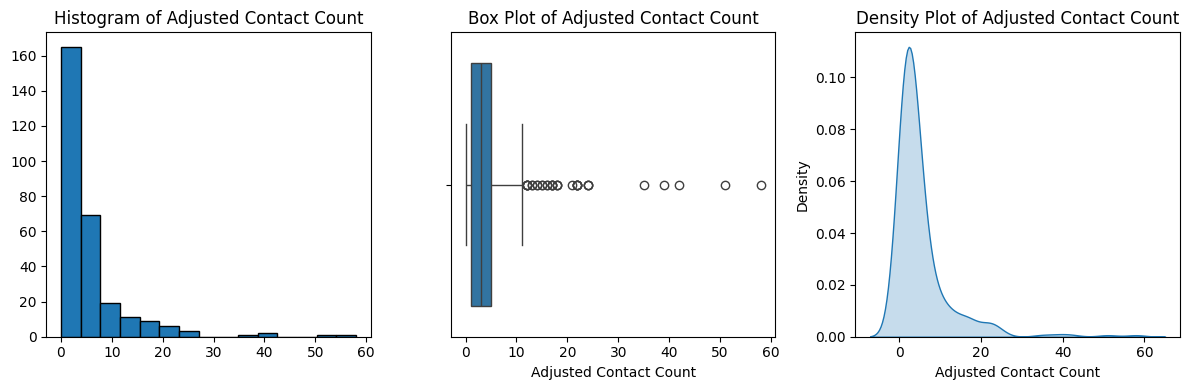

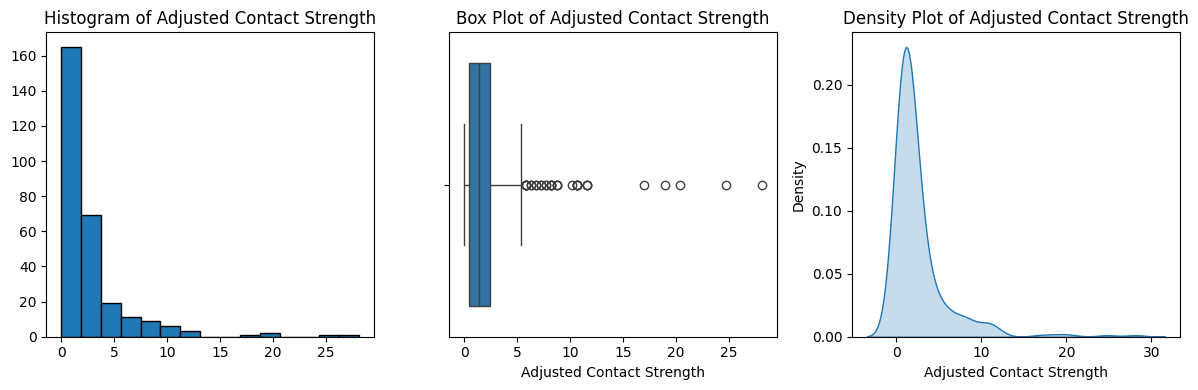

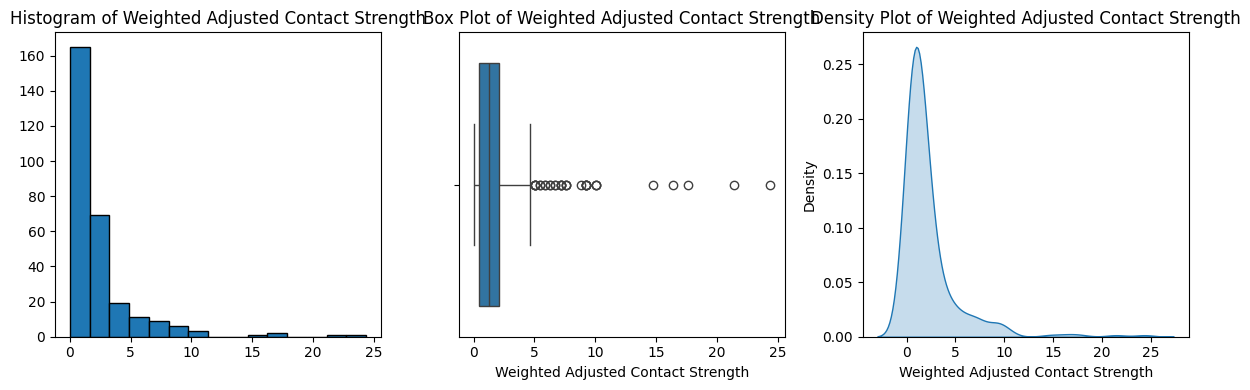

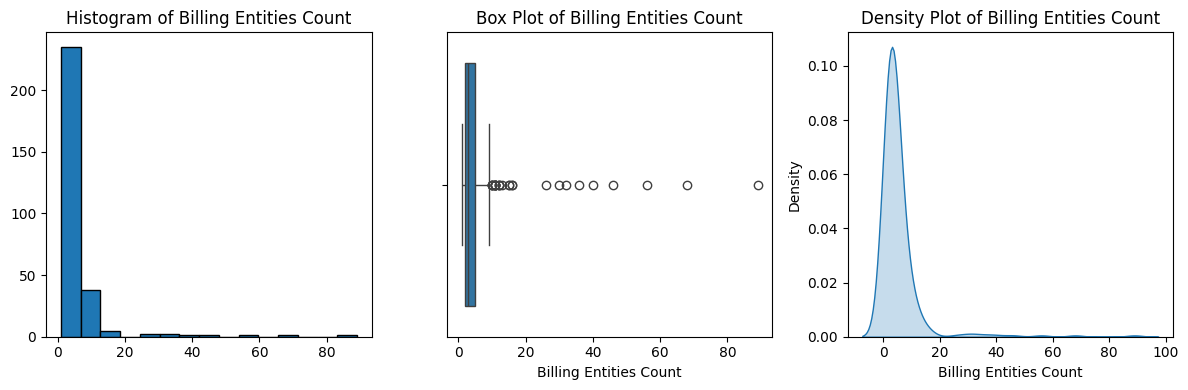

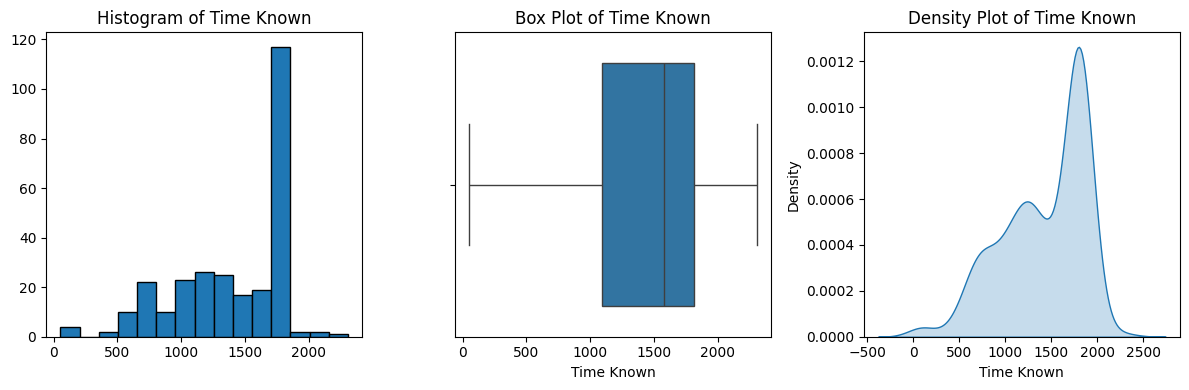

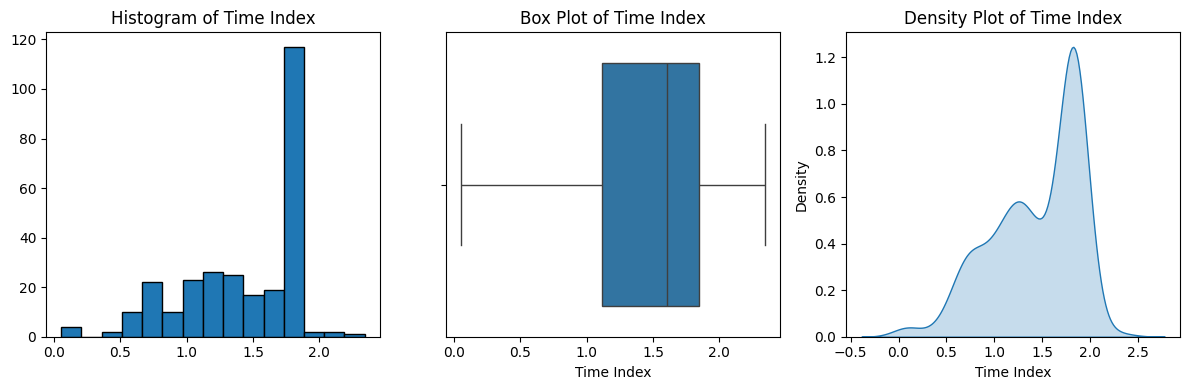

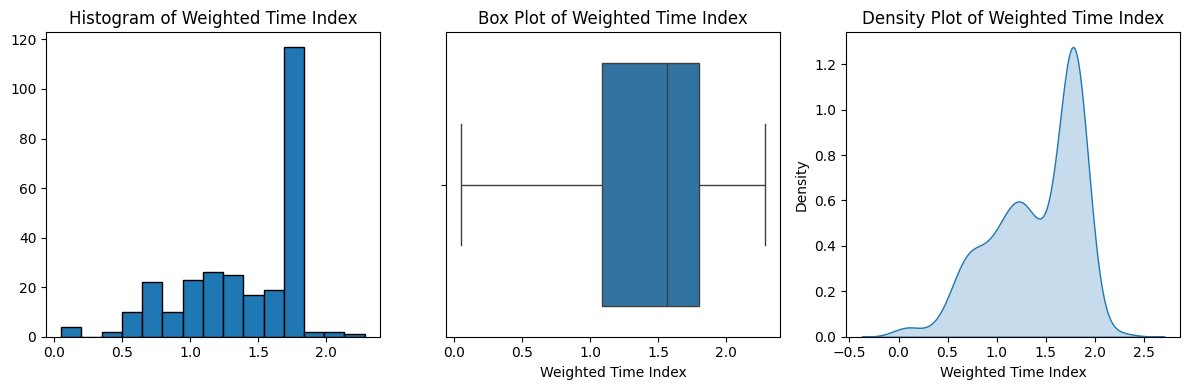

In [27]:
for col in df_slice_BE.select_dtypes(include=['number']).columns:
    if "ID" in col: continue
    plt.figure(figsize=(12, 4))
    
    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(df_slice_BE[col].dropna(), bins=15, edgecolor='k')
    plt.title(f"Histogram of {col}")

    # Box Plot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=df_slice_BE[col])
    plt.title(f"Box Plot of {col}")

    # Density Plot
    plt.subplot(1, 3, 3)
    sns.kdeplot(df_slice_BE[col].dropna(), fill=True)
    plt.title(f"Density Plot of {col}")
    
    plt.tight_layout()
    plt.show()

In [28]:
results = {}

for col in df_slice_BE.select_dtypes(include=["number"]).columns:
    if "ID" in col: continue
    data = df_slice_BE[col].dropna()
    
    # Shapiro-Wilk Test
    shapiro_test = shapiro(data)
    # Kolmogorov-Smirnov Test
    ks_test = normaltest(data)
    # Anderson-Darling Test
    anderson_test = anderson(data)
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
    
    # Z-Score Method
    z_scores = zscore(data)
    z_outliers = data[np.abs(z_scores) > 3]
    
    results[col] = {
        'Shapiro-Wilk p-value': shapiro_test.pvalue,
        'Kolmogorov-Smirnov p-value': ks_test.pvalue,
        'Anderson-Darling statistic': anderson_test.statistic,
        'IQR Outliers Count': iqr_outliers.count(),
        'Z-Score Outliers Count': z_outliers.count()
    }

# Create a DataFrame from the normality_results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')
# Rename columns for clarity
results_df.columns = ['Shapiro-Wilk', 'Kolmogorov-Smirnov', 'Anderson-Darling','Outlier','Z-score']
results_df

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,Outlier,Z-score
Likelihood to close,4.109383e-32,2.025246e-81,83.739094,31,6
Number of Associated Contacts,3.179781e-25,2.295711e-51,34.564877,28,7
Number of times contacted,1.249389e-19,2.747285e-34,17.328484,16,7
Child Company Count,7.571476e-31,1.563344e-62,79.067222,39,9
Number of Appointments,2.550690e-29,5.951404e-54,71.338421,46,10
Familiarity Score,7.749983e-32,3.049967e-99,73.812791,46,5
Associated Note Count,3.083145e-11,1.809163e-10,5.662773,6,3
Associated Note Strength,3.083145e-11,1.809163e-10,5.662773,6,3
Weighted Associated Note Strength,3.083145e-11,1.809163e-10,5.662773,6,3
Adjusted Note Count,8.632143e-14,9.017407e-14,8.964367,7,4


#### Is Billing Entity == False Analysis

##### Descriptive Statistics (Is Billing Entity == False)

In [23]:
df_slice_Not_BE = working_df[working_df['Is Billing Entity'] == False]

In [18]:
df_slice_Not_BE.select_dtypes(include=['number']).describe()

,Record ID,Likelihood to close,Number of Associated Contacts,Number of times contacted,Child Company Count,Number of Appointments,Familiarity Score,Associated Note Count,Associated Note Strength,Weighted Associated Note Strength,Adjusted Note Count,Adjusted Note Strength,Weighted Adjusted Note Strength,Associated Contact Strength,Weighted Associated Contact Strength,Adjusted Contact Count,Adjusted Contact Strength,Weighted Adjusted Contact Strength,Billing Entities Count,Time Known,Time Index,Weighted Time Index
count,2.952000e+03,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.0,2768.000000,2768.000000,2768.000000
mean,8.366145e+09,2.793608,2.218157,13.471883,0.057588,0.484417,0.456781,1.700542,0.986640,0.524194,1.080962,0.960031,0.414693,0.881395,0.817315,1.835705,0.891269,0.771404,0.0,938.822616,0.952796,0.929334
std,4.984300e+09,3.746468,2.506752,22.034289,0.412532,0.719408,0.677116,2.546037,1.477189,0.784818,1.829171,1.624536,0.701730,0.996069,0.923652,2.065294,1.002739,0.867883,0.0,552.141808,0.560360,0.546562
min,6.639429e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.001015,0.000990
25%,4.887485e+09,0.527500,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397354,0.368466,1.000000,0.485518,0.420222,0.0,446.000000,0.452638,0.441492
50%,8.186529e+09,1.620000,1.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.580192,0.308251,0.000000,0.000000,0.000000,0.397354,0.368466,1.000000,0.485518,0.420222,0.0,783.500000,0.795162,0.775581
75%,1.157763e+10,3.670000,3.000000,18.000000,0.000000,1.000000,1.000000,2.000000,1.160383,0.616502,1.000000,0.888127,0.383633,1.192063,1.105397,2.000000,0.971037,0.840445,0.0,1299.000000,1.318334,1.285872
max,2.042355e+10,55.510000,30.000000,430.000000,9.000000,6.000000,6.000000,23.000000,13.344407,7.089771,14.000000,12.433775,5.370861,11.920635,11.053968,26.000000,12.623481,10.925782,0.0,2294.000000,2.328144,2.270815


#### 5. Data Transformations

### Step 4. Bi-variate/Multivariate Analysis

In [ ]:
# Correlation matrix for numerical variables including the target variable
correlation_matrix = final_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for first time clients")
plt.show()

# Correlation matrix for numerical variables including the target variable
correlation_matrix = first_time_be_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for first time clients")
plt.show()

# Correlation matrix for numerical variables including the target variable
correlation_matrix = repeat_be_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for repeat clients")
plt.show()

# Correlation matrix for numerical variables including the target variable
correlation_matrix = non_be_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for non-clients")
plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=first_time_be_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=first_time_be_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=be_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    ('Associated Note_count', 'First_Sales_Cycle_Duration'),
    ('Number of times contacted', 'First_Sales_Cycle_Duration'),
    ('Number of Associated Contacts', 'First_Sales_Cycle_Duration'),
    ('Associated Note_count', 'BE_count'),
    ('Number of Associated Contacts', 'BE_count'),
    ('Number of times contacted', 'BE_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=final_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Iterate through each ICP category and each pair to plot
for x_col, y_col in pairs_to_plot:  
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(x=x_col, y=y_col, data=first_time_be_df)
    plt.title(f'Scatter Plot of {x_col} vs {y_col} for first time clients')
    plt.xlabel(x_col, color='red')
    plt.ylabel(y_col)

    # Optionally, add a regression line
    sns.regplot(x=x_col, y=y_col, data=first_time_be_df, scatter=False, color='red')

    # Show the plot
    plt.xlim(0, 30)
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Iterate through each ICP category and each pair to plot
for x_col, y_col in pairs_to_plot:  
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(x=x_col, y=y_col, data=first_time_be_df)
    plt.title(f'Scatter Plot of {x_col} vs {y_col} for first time clients')
    plt.xlabel(x_col, color='red')
    plt.ylabel(y_col)

    # Optionally, add a regression line
    sns.regplot(x=x_col, y=y_col, data=first_time_be_df, scatter=True, color='red')

    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Number of Associated Contacts', 'First_Sales_Cycle_Duration'),
    # Add more pairs as needed
]

# Iterate through each ICP category and each pair to plot
for category in icp_columns:
    for x_col, y_col in pairs_to_plot:
        # Filter the DataFrame for the current ICP category
        filtered_df = non_be_df[non_be_df[category] == 1]
        filtered_df
        
        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=x_col, y=y_col, data=filtered_df)
        plt.title(f'Scatter Plot of {x_col} vs {y_col} for {category}')
        plt.xlabel(x_col, color='red')
        plt.ylabel(y_col)

        # Optionally, add a regression line
        sns.regplot(x=x_col, y=y_col, data=filtered_df, scatter=False, color='red')

        # Show the plot
        plt.show()

In [ ]:
# Analyze relationships between categorical variables and the target variable using count plots
fig, axes = plt.subplots(len(categorical_columns) - 1, 1, figsize=(8, 24))  # Exclude target variable from analysis
for i, col in enumerate(categorical_columns):  # Exclude 'Lung Cancer Occurrence'
    sns.countplot(x=col, hue='BE_Indicator', data=be_df, ax=axes[i])
    axes[i].set_title(f'{col} vs BillingEntity_Indicator')
    axes[i].legend(title='BE Indicator', loc='upper right')

plt.tight_layout()

#### Correlation Analysis:
- The correlation matrix primarily focused on numerical variables shows limited correlation between these variables and the lung cancer occurrence.
- This indicates that no single numerical factor strongly predicts lung cancer occurrence on its own
- THis also highlights the complexity of the disease and the potential need for a multifactorial approach to prediction.

#### Categorical Variables Analysis:
- **Gender**: There appears to be a difference in lung cancer occurrence between genders, suggesting that gender may play a role in lung cancer risk.
- **COPD History**: Patients with a history of COPD show a higher occurrence of lung cancer, indicating a potential link between COPD and lung cancer risk.
- **Genetic Markers**: The presence of genetic markers seems to correlate with a higher incidence of lung cancer, supporting the role of genetics in lung cancer risk.
- **Air Pollution Exposure**: Higher levels of air pollution exposure are associated with a greater occurrence of lung cancer, highlighting environmental factors in lung cancer risk.
- **Taken Bronchodilators**: The use of bronchodilators is more common among patients with lung cancer, which may reflect underlying respiratory conditions rather than a direct causative relationship.
- **Frequency of Tiredness**: There's a visible trend where increased tiredness frequency is associated with higher lung cancer occurrence, possibly indicating symptom severity or general health status.
- **Dominant Hand**: No clear relationship is observed between the dominant hand and lung cancer occurrence, suggesting that handedness is not a relevant factor in lung cancer risk.

### Conclusions from Bivariate/Multivariate Analysis:
- The analysis reveals that lung cancer occurrence is associated with several factors, including gender, COPD history, genetic markers, air pollution exposure, and potentially the severity of symptoms like tiredness.
- The relationships between these variables and lung cancer occurrence suggest that a combination of demographic, genetic, environmental, and health-related factors contribute to lung cancer risk.
- The lack of strong correlations among numerical variables and lung cancer occurrence emphasizes the need for a comprehensive approach that includes both numerical and categorical data in predicting lung cancer risk.
- The lack of strong correlation between dominant hand and lung cancer occurrence suggests that theis categorical variable can be removed 


### Step 5: Feature Engineering and Selection for Task 2

Based on the insights from the previous analyses, we can identify potential features that might improve the predictability of lung cancer occurrence and select the most relevant variables for modeling. Here's a proposed approach:

#### Feature Engineering:
- **Smoking Duration**: Calculate the duration of smoking as `Stop Smoking Year - Start Smoking Year`. This new feature could capture the impact of long-term smoking on lung cancer risk.
- **Weight Change**: Compute the weight change as `Current Weight - Last Weight`. This feature might indicate health changes that are relevant to lung cancer risk.
- **Age at Start Smoking**: Considering the age when the patient started smoking might provide insights into vulnerability due to early exposure.

#### Feature Selection:
- **Numerical Variables**: Include the newly engineered features (Smoking Duration, Weight Change, Age at Start Smoking) along with Age, as these directly relate to personal health status and behaviors that could influence lung cancer risk.
- **Categorical Variables**: Retain variables that showed significant associations with lung cancer occurrence in the bivariate analysis, including Gender, COPD History, Genetic Markers, and Air Pollution Exposure. The Frequency of Tiredness might also be included as it could reflect overall health status.


In [ ]:
# Feature Engineering
df_cleaned['Smoking Duration'] = df_cleaned['Stop Smoking'] - df_cleaned['Start Smoking']
df_cleaned['Weight Change'] = df_cleaned['Current Weight'] - df_cleaned['Last Weight']

# Assuming age at start smoking is 'Age' - ('Current Year' - 'Start Smoking Year')
# Using a fixed current year as 2024 for simplicity, since data analysis is being conducted in 2024
current_year = 2024
df_cleaned['Age at Start Smoking'] = df_cleaned['Age'] - (current_year - df_cleaned['Start Smoking'])

# Update the list of numerical columns to include the new features
numerical_columns_updated = ['Age', 'Smoking Duration', 'Weight Change', 'Age at Start Smoking']

# Selected categorical columns based on analysis
selected_categorical_columns = ['Gender', 'COPD History', 'Genetic Markers', 'Air Pollution Exposure', 'Frequency of Tiredness']

# Final dataset for modeling
final_features = numerical_columns_updated + selected_categorical_columns + ['Lung Cancer Occurrence']
df_modeling = df_cleaned[final_features]

# Display the first few rows of the updated DataFrame for modeling
df_modeling.head()

### New Features Created:

- **Smoking Duration**: Calculated as the difference between the stop and start years of smoking, providing a measure of the exposure duration to smoking.
- **Weight Change**: Represents the difference between the current and last recorded weights, potentially indicating health changes.
- **Age at Start Smoking**: Estimated age when the patient started smoking, offering insights into early exposure risks.

### Final Set of Variables:

- **Numerical Variables**: Age, Smoking Duration, Weight Change, and Age at Start Smoking.
- **Categorical Variables**: Gender, COPD History, Genetic Markers, Air Pollution Exposure, and Frequency of Tiredness.
- **Target Variable**: Lung Cancer Occurrence.

This refined dataset integrates both individual health-related behaviors and genetic/environmental factors, aiming to enhance the predictive accuracy for lung cancer occurrence. 
The inclusion of engineered features is expected to provide additional insights into the multifactorial nature of lung cancer risk.

## Conclusion

Throughout this Exploratory Data Analysis (EDA), I have navigated through the various stages necessary to understand and prepare the dataset for further analysis and modeling, specifically focusing on the risk factors associated with lung cancer occurrence. Here's a summary of my key findings and actions:

1. **Data Loading and Initial Inspection**: I commenced by loading the dataset and conducting an initial inspection, identifying the structure, data types, and potential issues such as missing values and outliers.

2. **Data Cleaning**: This phase involved converting data types for better analysis, handling missing values, and addressing outliers, particularly in the `Age` attribute, to ensure data integrity and reliability.

3. **Univariate Analysis**: I analyzed individual variables to understand their distributions and identify patterns. This revealed insights into patient demographics, health behaviors, and clinical attributes, highlighting significant variances and outliers in some key variables.

4. **Bivariate/Multivariate Analysis**: The relationships between variables and lung cancer occurrence were explored, indicating that factors such as gender, COPD history, genetic markers, and air pollution exposure are associated with lung cancer risks. This phase underscored the multifactorial nature of lung cancer, suggesting the need for a comprehensive approach to prediction.

5. **Feature Engineering and Selection**: Based on the insights gained, new features were created to capture aspects like smoking duration and weight change, which are potentially indicative of lung cancer risk. A subset of variables was selected for modeling, balancing between numerical and categorical data to enhance the predictive model's accuracy.